# DAVID BORN AND SAM EWING
# GROUP PROJECT 1
# CRIME RELATING TO DISPENSARY LOCATION IN DENVER COLORADO

## Analysis Report will be found at the end of this notebook

In [1]:
# Setting up dependancies and external modules
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import requests
import json

# Geocoding dependancies
import geopandas as gpd
import folium
from shapely.geometry import Point, Polygon

# import library for computing distances between stores and crimes
from haversine import haversine, Unit

# Google API Key
from config import gkey


In [2]:
# Cell 1

# Reading .csvs and other files

# NOTE - Additional CSVs will be created and referenced in the code. These files will be read-in after their creation.

# Reading Marijuana Active Business Licenses CSV
file_mari_licenses = ('Raw_data/marijuana_active_business_licenses.csv')
raw_mari_licenses_df = pd.read_csv(file_mari_licenses)

# Reading Denver Police Districts CSV
# Note - This file is the CSV version. A .GeoJSON version of this document will be read-in and introduced later in the code
file_police_districts = ('Raw_data/police_districts.csv')
police_districts_df = pd.read_csv(file_police_districts)

# police_districts_df - Renaming columns to remove "_"
police_districts_df = police_districts_df.rename(columns = {
    "DIST_NUM" : "DISTRICT NUMBER",
    "GLOBALID" : "GLOBAL ID",
    "SHAPE_Length" : "SHAPE LENGTH",
    "SHAPE_Area" : "SHAPE AREA"
    })

# Reading Denver Crime Data CSV
file_dpd_crime = ('Raw_data/crime_zip.zip')
raw_crime_data_df = pd.read_csv(file_dpd_crime, compression = 'zip')

# raw_crime_data_df - Renaming columns to remove "_"
crime_data_df = raw_crime_data_df.rename(columns = {
    "INCIDENT_ID" : "INCIDENT ID",
    "OFFENSE_ID" : "OFFENSE ID",
    "OFFENSE_CODE" : "OFFENSE CODE",
    "OFFENSE_CODE_EXTENSION" : "OFFENSE CODE EXTENSION",
    "OFFENSE_TYPE_ID" : "OFFENSE TYPE ID",
    "OFFENSE_CATEGORY_ID" : "OFFENSE CATEGORY ID",
    "FIRST_OCCURRENCE_DATE" : "FIRST OCCURRENCE DATE",
    "LAST_OCCURRENCE_DATE" : "LAST OCCURRENCE DATE",
    "REPORTED_DATE" : "REPORTED DATE",
    "INCIDENT_ADDRESS" : "INCIDENT ADDRESS",
    "GEO_X" : "GEO X",
    "GEO_Y" : "GEO Y",
    "GEO_LON" : "GEO LON",
    "GEO_LAT" : "GEO LAT",
    "DISTRICT_ID" : "DISTRICT ID",
    "PRECINCT_ID" : "PRECINCT ID",
    "NEIGHBORHOOD_ID" : "NEIGHBORHOOD ID",
    "IS_CRIME" : "IS CRIME",
    "IS_TRAFFIC" : "IS TRAFFIC"
    })

crime_data_df['YEAR'] = crime_data_df['INCIDENT ID'].astype(str).str[:4].astype(int)
crime_data_df

,INCIDENT ID,OFFENSE ID,OFFENSE CODE,OFFENSE CODE EXTENSION,OFFENSE TYPE ID,OFFENSE CATEGORY ID,FIRST OCCURRENCE DATE,LAST OCCURRENCE DATE,REPORTED DATE,INCIDENT ADDRESS,GEO X,GEO Y,GEO LON,GEO LAT,DISTRICT ID,PRECINCT ID,NEIGHBORHOOD ID,IS CRIME,IS TRAFFIC,YEAR
0,2016376978,2016376978521300,5213,0,weapon-unlawful-discharge-of,all-other-crimes,6/15/2016 11:31:00 PM,NaN,6/15/2016 11:31:00 PM,NaN,3193983.0,1707251.0,-104.809881,39.773188,5,521,montbello,1,0,2016
1,20186000994,20186000994239900,2399,0,theft-other,larceny,10/11/2017 12:30:00 PM,10/11/2017 4:55:00 PM,1/29/2018 5:53:00 PM,NaN,3201943.0,1711852.0,-104.781434,39.785649,5,522,gateway-green-valley-ranch,1,0,2018
2,20166003953,20166003953230500,2305,0,theft-items-from-vehicle,theft-from-motor-vehicle,3/4/2016 8:00:00 PM,4/25/2016 8:00:00 AM,4/26/2016 9:02:00 PM,2932 S JOSEPHINE ST,3152762.0,1667011.0,-104.957381,39.663490,3,314,wellshire,1,0,2016
3,201872333,201872333239900,2399,0,theft-other,larceny,1/30/2018 7:20:00 PM,NaN,1/30/2018 10:29:00 PM,705 S COLORADO BLVD,3157162.0,1681320.0,-104.941440,39.702698,3,312,belcaro,1,0,2018
4,2017411405,2017411405230300,2303,0,theft-shoplift,larceny,6/22/2017 8:53:00 PM,NaN,6/23/2017 4:09:00 PM,2810 E 1ST AVE,3153211.0,1686545.0,-104.955370,39.717107,3,311,cherry-creek,1,0,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518488,2019633275,2019633275240400,2404,0,theft-of-motor-vehicle,auto-theft,10/2/2019 9:00:00 PM,10/3/2019 10:26:00 AM,10/3/2019 10:26:00 AM,6000 BLK E SMITH RD,3163496.0,1707142.0,-104.918342,39.773475,2,221,northeast-park-hill,1,0,2019
518489,20195003987,20195003987361200,3612,0,sex-off-fail-to-register,all-other-crimes,8/14/2019 12:00:00 PM,NaN,10/2/2019 10:38:00 AM,5127 N CHANDLER WAY,3189819.0,1713044.0,-104.824541,39.789176,5,521,montbello,1,0,2019
518490,2019634461,2019634461120500,1205,0,robbery-street,robbery,10/3/2019 8:01:00 PM,NaN,10/3/2019 9:10:00 PM,E COLFAX AVE / N GRANT ST,3145226.0,1694854.0,-104.983587,39.740045,6,623,capitol-hill,1,0,2019
518491,2019633653,2019633653230300,2303,0,theft-shoplift,larceny,10/3/2019 1:32:00 PM,NaN,10/3/2019 2:41:00 PM,7900 W QUINCY AVE,3116548.0,1657295.0,-105.086170,39.637340,4,423,marston,1,0,2019


In [3]:
# Cell 2
summary_crime_data_df = crime_data_df[[
    "YEAR",
    "INCIDENT ID", 
    "OFFENSE CODE", 
    "OFFENSE TYPE ID", 
    "OFFENSE CATEGORY ID", 
    "FIRST OCCURRENCE DATE", 
    "REPORTED DATE", 
    "INCIDENT ADDRESS", 
    "GEO LON", 
    "GEO LAT", 
    "DISTRICT ID"]]
summary_crime_data_df

,YEAR,INCIDENT ID,OFFENSE CODE,OFFENSE TYPE ID,OFFENSE CATEGORY ID,FIRST OCCURRENCE DATE,REPORTED DATE,INCIDENT ADDRESS,GEO LON,GEO LAT,DISTRICT ID
0,2016,2016376978,5213,weapon-unlawful-discharge-of,all-other-crimes,6/15/2016 11:31:00 PM,6/15/2016 11:31:00 PM,NaN,-104.809881,39.773188,5
1,2018,20186000994,2399,theft-other,larceny,10/11/2017 12:30:00 PM,1/29/2018 5:53:00 PM,NaN,-104.781434,39.785649,5
2,2016,20166003953,2305,theft-items-from-vehicle,theft-from-motor-vehicle,3/4/2016 8:00:00 PM,4/26/2016 9:02:00 PM,2932 S JOSEPHINE ST,-104.957381,39.663490,3
3,2018,201872333,2399,theft-other,larceny,1/30/2018 7:20:00 PM,1/30/2018 10:29:00 PM,705 S COLORADO BLVD,-104.941440,39.702698,3
4,2017,2017411405,2303,theft-shoplift,larceny,6/22/2017 8:53:00 PM,6/23/2017 4:09:00 PM,2810 E 1ST AVE,-104.955370,39.717107,3
...,...,...,...,...,...,...,...,...,...,...,...
518488,2019,2019633275,2404,theft-of-motor-vehicle,auto-theft,10/2/2019 9:00:00 PM,10/3/2019 10:26:00 AM,6000 BLK E SMITH RD,-104.918342,39.773475,2
518489,2019,20195003987,3612,sex-off-fail-to-register,all-other-crimes,8/14/2019 12:00:00 PM,10/2/2019 10:38:00 AM,5127 N CHANDLER WAY,-104.824541,39.789176,5
518490,2019,2019634461,1205,robbery-street,robbery,10/3/2019 8:01:00 PM,10/3/2019 9:10:00 PM,E COLFAX AVE / N GRANT ST,-104.983587,39.740045,6
518491,2019,2019633653,2303,theft-shoplift,larceny,10/3/2019 1:32:00 PM,10/3/2019 2:41:00 PM,7900 W QUINCY AVE,-105.086170,39.637340,4


In [4]:
# Cell 3
# create copy of crime dataframe
crime_all_df = summary_crime_data_df        

In [5]:
# Cell 4
# create copy of crime dataframe
crime_all_df = summary_crime_data_df                    

# display copy
crime_all_df.head()

,YEAR,INCIDENT ID,OFFENSE CODE,OFFENSE TYPE ID,OFFENSE CATEGORY ID,FIRST OCCURRENCE DATE,REPORTED DATE,INCIDENT ADDRESS,GEO LON,GEO LAT,DISTRICT ID
0,2016,2016376978,5213,weapon-unlawful-discharge-of,all-other-crimes,6/15/2016 11:31:00 PM,6/15/2016 11:31:00 PM,NaN,-104.809881,39.773188,5
1,2018,20186000994,2399,theft-other,larceny,10/11/2017 12:30:00 PM,1/29/2018 5:53:00 PM,NaN,-104.781434,39.785649,5
2,2016,20166003953,2305,theft-items-from-vehicle,theft-from-motor-vehicle,3/4/2016 8:00:00 PM,4/26/2016 9:02:00 PM,2932 S JOSEPHINE ST,-104.957381,39.663490,3
3,2018,201872333,2399,theft-other,larceny,1/30/2018 7:20:00 PM,1/30/2018 10:29:00 PM,705 S COLORADO BLVD,-104.941440,39.702698,3
4,2017,2017411405,2303,theft-shoplift,larceny,6/22/2017 8:53:00 PM,6/23/2017 4:09:00 PM,2810 E 1ST AVE,-104.955370,39.717107,3


# Explore Crime Types and Categories

In [6]:
# Cell 5
# crime dataframe data types
crime_all_df.dtypes

YEAR                       int32
INCIDENT ID                int64
OFFENSE CODE               int64
OFFENSE TYPE ID           object
OFFENSE CATEGORY ID       object
FIRST OCCURRENCE DATE     object
REPORTED DATE             object
INCIDENT ADDRESS          object
GEO LON                  float64
GEO LAT                  float64
DISTRICT ID                int64
dtype: object

In [7]:
# Cell 6
# value counts by offense category
crime_all_df['OFFENSE CATEGORY ID'].value_counts()

traffic-accident                134835
all-other-crimes                 93698
public-disorder                  53921
larceny                          52631
theft-from-motor-vehicle         39312
drug-alcohol                     34025
auto-theft                       27603
other-crimes-against-persons     25543
burglary                         25519
aggravated-assault               12343
white-collar-crime                7071
robbery                           6732
sexual-assault                    4292
arson                              651
murder                             317
Name: OFFENSE CATEGORY ID, dtype: int64

In [8]:
# Cell 7
# create an offense dataframe
offense_df = crime_all_df.iloc[:,2:5]
offense_df.head()

,OFFENSE CODE,OFFENSE TYPE ID,OFFENSE CATEGORY ID
0,5213,weapon-unlawful-discharge-of,all-other-crimes
1,2399,theft-other,larceny
2,2305,theft-items-from-vehicle,theft-from-motor-vehicle
3,2399,theft-other,larceny
4,2303,theft-shoplift,larceny


In [9]:
# Cell 8
# Group by offense category and then by offense type to see how the types map to the categories
offense_type_cat_group = offense_df.groupby(['OFFENSE CATEGORY ID', 'OFFENSE TYPE ID'])
offense_type_cat_group.count()

OFFENSE CODE
OFFENSE CATEGORY ID OFFENSE TYPE ID                         
aggravated-assault  aggravated-assault                  5753
                    aggravated-assault-dv               2325
                    menacing-felony-w-weap              3395
                    weapon-fire-into-occ-bldg            691
                    weapon-fire-into-occ-veh             179
...                                                      ...
white-collar-crime  theft-confidence-game                 38
                    theft-embezzle                       163
                    theft-fail-return-rent-veh           480
                    theft-of-rental-property              44
                    theft-unauth-use-of-ftd              784

[201 rows x 1 columns]

# Retail Store Set-up

In [10]:
# Cell 9
# make copy of raw_mari_licenses_df to append Lat/Lng
licenses_df = raw_mari_licenses_df

In [11]:
# Cell 10
# change dtype of Zip to object
licenses_df['Facility Zip Code'] = licenses_df['Facility Zip Code'].astype(object)

In [12]:
# Cell 11
# create a new column with year, so that we can filter businesses by pre- and post-launch time frames
licenses_df['Year'] = licenses_df['Business File Number'].str[:4]

In [13]:
# Cell 12
# get rid of the 'NaN' in the dataframe to make the concat in the following cell work properly
licenses_df = licenses_df.fillna("")
licenses_df.head()

,Business File Number,License Type,Entity Name,Trade Name,Current License Status,Expiration Date,Facility Street Number,Facility Pre-Direction,Facility Street Name,Facility Street Type,Facility Unit Number,Facility City,Facility Zip Code,Year
0,2013-BFN-1069798,Retail Marijuana Store,"ARES STRATEGIES, INC",TERRAPIN CARE STATION,License Issued - Active,5/22/2020 0:00,1,,BROADWAY,,A-150,DENVER,80203,2013
1,2017-BFN-0003112,Retail Marijuana Inf Prod Mfg,SUSAN & STEPH INC,JADE & JANE,License Issued - Active,3/15/2020 0:00,1275,S,Cherokee,ST,,Denver,80223,2017
2,2017-BFN-0008899,Retail Marij Opt. Prem. Cultiv,MX LLC,,License Issued - Active,3/19/2020 0:00,3855,N,Quentin,St,,Denver,80239,2017
3,2010-BFN-1045920,Medical Marijuana Center,"3B-UMATILLA, LLC",BUDDY BOY,License Issued - Active,9/10/2020 0:00,777,N,UMATILLA,ST,,DENVER,80204,2010
4,2018-BFN-0003056,Marijuana Transporter,"GPS TRANSPORTATION, LLC",,License Issued - Active,8/14/2020 0:00,2186,S,Jason,St,,Denver,80223,2018


> Based on Google Geo API documentation, we need to concatenate address elements (street number, pre-direction, street name, street type) into a 'Street_Address' column.  The new 'Street_Address' column will be used for the API calls to append lat-lngs to store locations.  Note, 'Facility Unit Number' is not needed for the API calls.

In [14]:
# Cell 13
# Concatenate address elements (street number, pre-direction, street name, street type) into a 'Street_Address' column.

for index, row in licenses_df.iterrows():
    
    if pd.isnull(row['Facility Pre-Direction']) and pd.isnull(row['Facility Street Type']):
        
        licenses_df['Street_Address'] = licenses_df['Facility Street Number'].map(str) + " " + licenses_df['Facility Street Name']
    
    elif pd.isnull(row['Facility Pre-Direction']) and pd.notnull(row["Facility Street Type"]):
        
        licenses_df["Street_Address"] = licenses_df["Facility Street Number"].map(str) + " " + licenses_df["Facility Street Name"] + " " + licenses_df["Facility Street Type"]
        
    elif pd.notnull(row["Facility Pre-Direction"]) and pd.isnull(row['Facility Street Type']):    
        
        licenses_df["Street_Address"] = licenses_df["Facility Street Number"].map(str) + " " + licenses_df["Facility Pre-Direction"] + " " + licenses_df["Facility Street Name"]
        
    elif pd.notnull(row["Facility Pre-Direction"]) and pd.notnull(row["Facility Street Type"]):    
        
        licenses_df["Street_Address"] = licenses_df["Facility Street Number"].map(str) + " " + licenses_df["Facility Pre-Direction"] + " " + licenses_df["Facility Street Name"]+ " " + licenses_df["Facility Street Type"]  

In [15]:
# Cell 14
# display dataframe to inspect new 'Street_Address' column
licenses_df.head(10)

,Business File Number,License Type,Entity Name,Trade Name,Current License Status,Expiration Date,Facility Street Number,Facility Pre-Direction,Facility Street Name,Facility Street Type,Facility Unit Number,Facility City,Facility Zip Code,Year,Street_Address
0,2013-BFN-1069798,Retail Marijuana Store,"ARES STRATEGIES, INC",TERRAPIN CARE STATION,License Issued - Active,5/22/2020 0:00,1,,BROADWAY,,A-150,DENVER,80203,2013,1 BROADWAY
1,2017-BFN-0003112,Retail Marijuana Inf Prod Mfg,SUSAN & STEPH INC,JADE & JANE,License Issued - Active,3/15/2020 0:00,1275,S,Cherokee,ST,,Denver,80223,2017,1275 S Cherokee ST
2,2017-BFN-0008899,Retail Marij Opt. Prem. Cultiv,MX LLC,,License Issued - Active,3/19/2020 0:00,3855,N,Quentin,St,,Denver,80239,2017,3855 N Quentin St
3,2010-BFN-1045920,Medical Marijuana Center,"3B-UMATILLA, LLC",BUDDY BOY,License Issued - Active,9/10/2020 0:00,777,N,UMATILLA,ST,,DENVER,80204,2010,777 N UMATILLA ST
4,2018-BFN-0003056,Marijuana Transporter,"GPS TRANSPORTATION, LLC",,License Issued - Active,8/14/2020 0:00,2186,S,Jason,St,,Denver,80223,2018,2186 S Jason St
5,2015-BFN-0008211,Med Marijuana Inf Prod Manuf,"PEORIA PARTNERS, LLC",,License Issued - Active,10/31/2019 0:00,5475,N,PEORIA,ST,"2-104, 105",DENVER,80239,2015,5475 N PEORIA ST
6,2017-BFN-0006418,Retail Marijuana Inf Prod Mfg,GENTLEMAN QUINNS LLC,GENTLEMAN QUINNS,License Issued - Active,5/23/2020 0:00,2282,N,Broadway,,,Denver,,2017,2282 N Broadway
7,2014-BFN-0003960,Med Marijuana Opt Prem Cultiv,"PINEAPPLE EXCHANGE, LLC",PINEAPPLE EXCHANGE,License Issued - Active,5/11/2020 0:00,2218,S,KALAMATH,ST,A,DENVER,80223,2014,2218 S KALAMATH ST
8,2013-BFN-1069518,Retail Marijuana Store,"MEDICINAL WELLNESS CENTER, LLC",OASIS CANNABIS SUPERSTORE,License Issued - Active,2/26/2020 0:00,6359,E,EVANS,AVE,,DENVER,80222,2013,6359 E EVANS AVE
9,2013-BFN-1068623,Med Marijuana Opt Prem Cultiv,LEVELS IV INC,LEVELS IV INC,License Issued - Active,6/26/2020 0:00,5156,N,Clarkson,,2 Unit B,Denver,,2013,5156 N Clarkson


In [16]:
# Cell 15
# create a new dataframe of "Retail Marijuana Stores", excluding medical dispensaries, cultivation, production, and transport
retail_licenses_df = licenses_df.loc[licenses_df["License Type"] == "Retail Marijuana Store"]

In [17]:
# Cell 16
# further filter the retail stores for Denver addresses to align with the crime data
wip1_denver_retail_licenses_df = retail_licenses_df.loc[retail_licenses_df["Facility City"] == "DENVER"]

In [18]:
# Cell 17
# exclude the 2017 licensees because we intend to examine 2017-2018 crime for stores licensed before 2017
denver_retail_licenses_df = wip1_denver_retail_licenses_df.loc[wip1_denver_retail_licenses_df["Year"] != "2017"]


## API Calls to Append Latitude (Lat) and Longitude (Lng) Coordinates to Denver Stores

* The source crime data already has lat-lng coordinates identifying the location of each crime incident.
* Using Google Maps Geocode to append lat-lng coordinates to the store data, we will be able to calculate the distance of crimes from the stores.
* The distance calculations will enable assessment of crime activity in each store's neighborhood.

In [19]:
# Cell 18
# add new columns to Denver store dataframe in which to populate the Lat/Lng values
denver_retail_licenses_df["Lat"] = ""
denver_retail_licenses_df["Lng"] = ""

C:\Users\samew\Anaconda3\envs\geonew\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\samew\Anaconda3\envs\geonew\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### WARNING: The API calls in the next cell can take a minute or two to execute.

In [20]:
# Cell 19
# API calls to get Lat/Lng

# create a params dict that will be updated with new city each iteration
params = {"key": gkey}


for index, row in denver_retail_licenses_df.iterrows():
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    
    #https://maps.googleapis.com/maps/api/geocode/json?address=1600+Amphitheatre+Parkway,+Mountain+View,+CA&key=YOUR_API_KEY
    
    street_add = row['Street_Address']
    city = row['Facility City']
    state = "CO"
    zip5 = row['Facility Zip Code']

    # update address key value
    params['address'] = f"{street_add},{city},{state},{zip5}"
    
    
    # make request
    request = requests.get(base_url, params=params)
    
       
    # convert to json
    stores_lat_lng = request.json()
    
    try:
        # populate sample dataframe lat/Lng columns with values from request
        denver_retail_licenses_df.loc[index, "Lat"] = stores_lat_lng["results"][0]["geometry"]["location"]["lat"]
        denver_retail_licenses_df.loc[index, "Lng"] = stores_lat_lng["results"][0]["geometry"]["location"]["lng"]
    except:    
        denver_retail_licenses_df.loc[index, "Lat"] = ""
        denver_retail_licenses_df.loc[index, "Lng"] = ""

# display to confirm lat/lng appear
denver_retail_licenses_df.head()

C:\Users\samew\Anaconda3\envs\geonew\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Business File Number,License Type,Entity Name,Trade Name,Current License Status,Expiration Date,Facility Street Number,Facility Pre-Direction,Facility Street Name,Facility Street Type,Facility Unit Number,Facility City,Facility Zip Code,Year,Street_Address,Lat,Lng
0,2013-BFN-1069798,Retail Marijuana Store,"ARES STRATEGIES, INC",TERRAPIN CARE STATION,License Issued - Active,5/22/2020 0:00,1,,BROADWAY,,A-150,DENVER,80203,2013,1 BROADWAY,39.7169,-104.988
8,2013-BFN-1069518,Retail Marijuana Store,"MEDICINAL WELLNESS CENTER, LLC",OASIS CANNABIS SUPERSTORE,License Issued - Active,2/26/2020 0:00,6359,E,EVANS,AVE,,DENVER,80222,2013,6359 E EVANS AVE,39.6787,-104.915
17,2015-BFN-0000507,Retail Marijuana Store,"GREEN AROUND YOU, LLC","GOLDEN MEDS, INC.",License Issued - Active,6/22/2020 0:00,970,S,ONEIDA,ST,15,DENVER,80224,2015,970 S ONEIDA ST,39.6988,-104.907
27,2013-BFN-1069782,Retail Marijuana Store,DELTA-9 DELIGHTS LLC,REEFER MADNESS,License Issued - Active,6/2/2020 0:00,4401,E,46TH,AVE,B,DENVER,80216,2013,4401 E 46TH AVE,39.7812,-104.936
29,2014-BFN-1074182,Retail Marijuana Store,"SERENITY MOON WELLNESS CENTER, LLC",FROSTED LEAF,License Issued - Active,9/10/2020 0:00,6302,E,COLFAX,AVE,,DENVER,80220,2014,6302 E COLFAX AVE,39.7398,-104.915


#### After plotting the resultant geo-coded stores on a map, one store plotted significantly outside the Denver city boundaries.

In [21]:
# Cell 20
# remove the store that plots outside Denver city boundaries from the Denver store dataframe as it will skew neighborhood crime
denver_retail_licenses_df_final = denver_retail_licenses_df.loc[denver_retail_licenses_df["Business File Number"] != "2014-BFN-1070938"]


In [22]:
# Cell 21
# reset index and display
denver_retail_licenses_df_final.reset_index(drop=True)

,Business File Number,License Type,Entity Name,Trade Name,Current License Status,Expiration Date,Facility Street Number,Facility Pre-Direction,Facility Street Name,Facility Street Type,Facility Unit Number,Facility City,Facility Zip Code,Year,Street_Address,Lat,Lng
0,2013-BFN-1069798,Retail Marijuana Store,"ARES STRATEGIES, INC",TERRAPIN CARE STATION,License Issued - Active,5/22/2020 0:00,1,,BROADWAY,,A-150,DENVER,80203,2013,1 BROADWAY,39.7169,-104.988
1,2013-BFN-1069518,Retail Marijuana Store,"MEDICINAL WELLNESS CENTER, LLC",OASIS CANNABIS SUPERSTORE,License Issued - Active,2/26/2020 0:00,6359,E,EVANS,AVE,,DENVER,80222,2013,6359 E EVANS AVE,39.6787,-104.915
2,2015-BFN-0000507,Retail Marijuana Store,"GREEN AROUND YOU, LLC","GOLDEN MEDS, INC.",License Issued - Active,6/22/2020 0:00,970,S,ONEIDA,ST,15,DENVER,80224,2015,970 S ONEIDA ST,39.6988,-104.907
3,2013-BFN-1069782,Retail Marijuana Store,DELTA-9 DELIGHTS LLC,REEFER MADNESS,License Issued - Active,6/2/2020 0:00,4401,E,46TH,AVE,B,DENVER,80216,2013,4401 E 46TH AVE,39.7812,-104.936
4,2014-BFN-1074182,Retail Marijuana Store,"SERENITY MOON WELLNESS CENTER, LLC",FROSTED LEAF,License Issued - Active,9/10/2020 0:00,6302,E,COLFAX,AVE,,DENVER,80220,2014,6302 E COLFAX AVE,39.7398,-104.915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,2013-BFN-1069633,Retail Marijuana Store,"GM SANTA FE, LLC",GOLDEN MEDS,License Issued - Active,9/10/2020 0:00,1410,S,SANTA FE,DR,,DENVER,80223,2013,1410 S SANTA FE DR,39.6909,-104.992
136,2013-BFN-1069051,Retail Marijuana Store,"NATURES CURE III, LLC",THE COLFAX POT SHOP,License Issued - Active,3/19/2020 0:00,1500,E,COLFAX,AVE,,DENVER,80218,2013,1500 E COLFAX AVE,39.7398,-104.969
137,2014-BFN-0004646,Retail Marijuana Store,"GMC, LLC",GREEN MAN CANNABIS,License Issued - Active,3/6/2020 0:00,7289,E,HAMPDEN,AVE,,DENVER,80224,2014,7289 E HAMPDEN AVE,39.6535,-104.904
138,2013-BFN-1069170,Retail Marijuana Store,"SWEETWATER PARTNERS, LLC",GOOD CHEMISTRY,License Issued - Active,1/13/2020 0:00,1724,S,BROADWAY,,,DENVER,80210,2013,1724 S BROADWAY,39.6852,-104.987


In [23]:
# Cell 22
# display final Denver store counts by year licensed
denver_retail_licenses_df_final['Year'].value_counts()

2013    83
2014    24
2015    22
2016    11
Name: Year, dtype: int64

In [24]:
# Cell 23
# save dataframe to csv as this is the Denver store sample population; the csv can be read into Jupyter when needed
denver_retail_licenses_df_final.to_csv("Raw_data/denver_retail_licenses_df_final.csv",
                  encoding="utf-8", index=False, header=True)

In [25]:
# Cell 24
# Reading-in New Retail Licenses CSV for future use
file_weed_stores = ('Raw_data/denver_retail_licenses_df_final.csv')
weed_store_df = pd.read_csv(file_weed_stores)

#### code in the following cell can be copied to read in the Denver store population

## Creation of Sample Stores that Were Licensed AFTER 2014 (aka post-14 stores)

* There are 33 stores that were licensed in 2015 and 2016.
* These stores will serve as a sample to examine neighborhood crime in 2014 BEFORE the stores were licensed.
* The 2014 crime activity will be compared to neighborhood crime in 2018 AFTER the stores were licensed.
> Downstream in this script, there will be a separate sample of stores that were licensed in 2013 (aka pre-14 stores). These stores will be used to compare crime activity to the post-14 stores, since the pre-14 stores had their operating licenses for both 2014 and 2018.  

In [26]:
# Cell 25
# filter the Denver store dataframe for stores that were licensed in 2015-2016 (aka post-14 stores)
denver_retail_licenses_df_2015_16 = denver_retail_licenses_df_final.loc[denver_retail_licenses_df_final["Year"] > "2014"]

In [27]:
# Cell 26
denver_retail_licenses_df_2015_16.reset_index(drop=True)

,Business File Number,License Type,Entity Name,Trade Name,Current License Status,Expiration Date,Facility Street Number,Facility Pre-Direction,Facility Street Name,Facility Street Type,Facility Unit Number,Facility City,Facility Zip Code,Year,Street_Address,Lat,Lng
0,2015-BFN-0000507,Retail Marijuana Store,"GREEN AROUND YOU, LLC","GOLDEN MEDS, INC.",License Issued - Active,6/22/2020 0:00,970,S,ONEIDA,ST,15,DENVER,80224,2015,970 S ONEIDA ST,39.6988,-104.907
1,2016-BFN-0004024,Retail Marijuana Store,"LEVELS IV, INC",LEVELS IV INC,License Issued - Active,11/25/2020 0:00,5201,W,48TH,AVE,,DENVER,80212,2016,5201 W 48TH AVE,39.784,-105.054
2,2015-BFN-0007821,Retail Marijuana Store,"ROYAL ASSET MANAGEMENT, LLC",DIEGO PELLICER,License Issued - Active,11/7/2020 0:00,2949,W,ALAMEDA,AVE,,DENVER,80219,2015,2949 W ALAMEDA AVE,39.7115,-105.024
3,2016-BFN-0004033,Retail Marijuana Store,HOBBY FARMS LLC,A CUT ABOVE,License Issued - Active,7/6/2020 0:00,1911,S,BROADWAY,,,DENVER,80210,2016,1911 S BROADWAY,39.6819,-104.988
4,2015-BFN-0001350,Retail Marijuana Store,PG RETAIL I LLC,MILE HIGH GREEN CROSS,License Issued - Active,7/2/2020 0:00,852,N,BROADWAY,,,DENVER,80203,2015,852 N BROADWAY,39.7301,-104.987
5,2016-BFN-0007402,Retail Marijuana Store,"YUMA WAY, LLC",1136 YUMA,License Issued - Active,11/6/2019 0:00,1136,N,YUMA,CT,,DENVER,80204,2016,1136 N YUMA CT,39.7343,-105.014
6,2016-BFN-0004809,Retail Marijuana Store,"SMOKED COLORADO, INC.",MIGHTY TREE,License Issued - Active,11/23/2019 0:00,2268,S,DELAWARE,ST,,DENVER,80223,2016,2268 S DELAWARE ST,39.6755,-104.992
7,2016-BFN-0004876,Retail Marijuana Store,"TWO G-FEDERAL, LLC",BUDDY BOY,License Issued - Active,8/16/2020 0:00,2426,S,FEDERAL,BLVD,,DENVER,80219,2016,2426 S FEDERAL BLVD,39.6726,-105.025
8,2015-BFN-0000352,Retail Marijuana Store,"MILE HIGH DISPENSARY, LLC",MILE HIGH DISPENSARY,License Issued - Active,2/26/2020 0:00,1350,S,SHERIDAN,BLVD,1 & 2,DENVER,80232,2015,1350 S SHERIDAN BLVD,39.6919,-105.053
9,2015-BFN-0003926,Retail Marijuana Store,"GREENFIELDS, LLC",GREENFIELDS,License Issued - Active,11/9/2019 0:00,1798,W,MISSISSIPPI,AVE,,DENVER,80223,2015,1798 W MISSISSIPPI AVE,39.6964,-105.008


In [28]:
# Cell 27
# display year licensed
denver_retail_licenses_df_2015_16['Year'].value_counts()

2015    22
2016    11
Name: Year, dtype: int64

# Collect "Before and After" Crime Activity for Stores Licensed After 2014

## Stores Licensed AFTER 2014

## 2014 Crime

In [29]:
# Cell 28
# Filter the crime dataframe on 'YEAR' to get 2014 crime
crime14_all_df = crime_all_df.loc[crime_all_df["YEAR"] == 2014]

In [30]:
# Cell 29
# create a new 2014 crime dataframe that will be populated with distances from the post-14 stores
crime14xstore1516_all_df = crime14_all_df[['INCIDENT ID','OFFENSE CODE','OFFENSE CATEGORY ID','GEO LON','GEO LAT','DISTRICT ID','YEAR']]
crime14xstore1516_all_df.head()

,INCIDENT ID,OFFENSE CODE,OFFENSE CATEGORY ID,GEO LON,GEO LAT,DISTRICT ID,YEAR
18978,2014478770,5441,traffic-accident,-104.973130,39.674578,3,2014
51768,2014125067,1315,aggravated-assault,-105.025426,39.755872,1,2014
51769,2014125081,2399,larceny,-104.990215,39.751720,6,2014
51770,2014125098,5441,traffic-accident,-105.052572,39.728345,1,2014
51771,2014125111,5441,traffic-accident,-105.014047,39.736908,1,2014


### WARNING: The nested loops in the next cell can take 10+ minutes to execute and perhaps much longer.

#### Execution time will depend on the number of crime years and stores involved in the build. 

In [31]:
# Cell 30
# nested "for loops" to compute distance from each store to each crime

# the first loop calls each store
for index, row in denver_retail_licenses_df_2015_16.iterrows():
    store_location = (row['Lat'], row['Lng'])
    store_num_list = []
    store_num_list.append(row['Business File Number'])
    distance_list = []
    
    # the second loop calls each crime
    for index, row in crime14xstore1516_all_df.iterrows():
        crime_location = (row['GEO LAT'], row['GEO LON'])
        distance = haversine(store_location, crime_location, unit='mi')
        distance_list.append(distance)
        
    # print(distance_list)   # for testing, output distance lists, commented out for final execution
    
    # create new column in crime dataframe with Store ID as the column header and value as the distance from store to crimes
    crime14xstore1516_all_df[str(store_num_list[0])] = distance_list
    crime14xstore1516_all_df[str(store_num_list[0])] = crime14xstore1516_all_df[str(store_num_list[0])].astype(float)

C:\Users\samew\Anaconda3\envs\geonew\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\samew\Anaconda3\envs\geonew\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [32]:
# Cell 31
# display dataframe for inspection
crime14xstore1516_all_df.head()

,INCIDENT ID,OFFENSE CODE,OFFENSE CATEGORY ID,GEO LON,GEO LAT,DISTRICT ID,YEAR,2015-BFN-0000507,2016-BFN-0004024,2015-BFN-0007821,...,2015-BFN-0006731,2015-BFN-0004354,2015-BFN-0001752,2016-BFN-0003367,2015-BFN-0002149,2015-BFN-0001109,2015-BFN-0008113,2016-BFN-0004094,2016-BFN-0004411,2015-BFN-0000239
18978,2014478770,5441,traffic-accident,-104.973130,39.674578,3,2014,3.883385,8.687246,3.735297,...,6.054600,6.597460,5.746804,2.408555,7.021358,1.478430,4.445493,7.751043,7.309453,9.283286
51768,2014125067,1315,aggravated-assault,-105.025426,39.755872,1,2014,7.416661,2.453798,3.067109,...,6.853185,2.656642,1.285333,3.911614,0.980730,5.735743,2.142390,9.522735,5.253716,9.465550
51769,2014125081,2399,larceny,-104.990215,39.751720,6,2014,5.729124,4.038250,3.322514,...,4.960986,1.396707,2.707857,3.413725,2.015304,5.329523,1.031740,10.298591,3.594049,7.642913
51770,2014125098,5441,traffic-accident,-105.052572,39.728345,1,2014,7.990631,3.848290,1.894174,...,8.255852,4.857066,1.105163,3.319499,3.321066,4.594562,3.198624,7.178088,7.279644,11.215392
51771,2014125111,5441,traffic-accident,-105.014047,39.736908,1,2014,6.258424,3.874318,1.841579,...,6.170925,2.950305,1.351609,2.474907,2.276549,4.332205,1.095231,8.721703,5.195838,9.085905


In [33]:
# Cell 32
# output dataframe to csv; the csv can be read into Jupyter when needed rather than go through the creation process from scratch
crime14xstore1516_all_df.to_csv("Raw_data/crime14xstore1516_all_df.csv",
                  encoding="utf-8", index=False, header=True)

In [34]:
# Cell 33
# create a new dataframe with only the store-to-crime distances; df will be used to count crimes by distance categories
distance_crime14xstore1516_all = crime14xstore1516_all_df.iloc[:,7:]

distance_crime14xstore1516_all.head()

,2015-BFN-0000507,2016-BFN-0004024,2015-BFN-0007821,2016-BFN-0004033,2015-BFN-0001350,2016-BFN-0007402,2016-BFN-0004809,2016-BFN-0004876,2015-BFN-0000352,2015-BFN-0003926,...,2015-BFN-0006731,2015-BFN-0004354,2015-BFN-0001752,2016-BFN-0003367,2015-BFN-0002149,2015-BFN-0001109,2015-BFN-0008113,2016-BFN-0004094,2016-BFN-0004411,2015-BFN-0000239
18978,3.883385,8.687246,3.735297,0.942178,3.906157,4.671743,1.007673,2.742126,4.401013,2.404046,...,6.054600,6.597460,5.746804,2.408555,7.021358,1.478430,4.445493,7.751043,7.309453,9.283286
51768,7.416661,2.453798,3.067109,5.484515,2.706523,1.602476,5.831298,5.756911,4.652077,4.207206,...,6.853185,2.656642,1.285333,3.911614,0.980730,5.735743,2.142390,9.522735,5.253716,9.465550
51769,5.729124,4.038250,3.322514,4.827673,1.504076,1.756351,5.268791,5.767492,5.303660,3.940354,...,4.960986,1.396707,2.707857,3.413725,2.015304,5.329523,1.031740,10.298591,3.594049,7.642913
51770,7.990631,3.848290,1.894174,4.696403,3.482324,2.074647,4.867960,4.131184,2.517303,3.224378,...,8.255852,4.857066,1.105163,3.319499,3.321066,4.594562,3.198624,7.178088,7.279644,11.215392
51771,6.258424,3.874318,1.841579,4.045286,1.508586,0.179883,4.402751,4.481874,3.728544,2.814099,...,6.170925,2.950305,1.351609,2.474907,2.276549,4.332205,1.095231,8.721703,5.195838,9.085905


In [35]:
# Cell 34
# count crimes by distance categories

count_0_1 = distance_crime14xstore1516_all[distance_crime14xstore1516_all <= 0.1].count()
count_1_2 = distance_crime14xstore1516_all[distance_crime14xstore1516_all <= 0.2].count()
count_2_3 = distance_crime14xstore1516_all[distance_crime14xstore1516_all <= 0.3].count()
count_3_4 = distance_crime14xstore1516_all[distance_crime14xstore1516_all <= 0.4].count()
count_4_5 = distance_crime14xstore1516_all[distance_crime14xstore1516_all <= 0.5].count()
count_5_6 = distance_crime14xstore1516_all[distance_crime14xstore1516_all <= 0.6].count()
count_6_7 = distance_crime14xstore1516_all[distance_crime14xstore1516_all <= 0.7].count()
count_7_8 = distance_crime14xstore1516_all[distance_crime14xstore1516_all <= 0.8].count()
count_8_9 = distance_crime14xstore1516_all[distance_crime14xstore1516_all <= 0.9].count()
count_9_10 = distance_crime14xstore1516_all[distance_crime14xstore1516_all <= 1.0].count()
count_10_11 = distance_crime14xstore1516_all[distance_crime14xstore1516_all <= 1.1].count()
count_11_12 = distance_crime14xstore1516_all[distance_crime14xstore1516_all <= 1.2].count()
count_12_13 = distance_crime14xstore1516_all[distance_crime14xstore1516_all <= 1.3].count()
count_13_14 = distance_crime14xstore1516_all[distance_crime14xstore1516_all <= 1.4].count()
count_14_15 = distance_crime14xstore1516_all[distance_crime14xstore1516_all <= 1.5].count()

In [36]:
# Cell 35
# this new dataframe puts compiles the crime incidents by distance category; but this is a throwaway dataframe used to get the 
# columns headers for the x_axis plotting
distance_crime14xstore1516_plot_df = pd.DataFrame({
                                                "0.1": count_0_1,
                                                "0.2": count_1_2,
                                                "0.3": count_2_3,
                                                "0.4": count_3_4,
                                                "0.5": count_4_5,
                                                "0.6": count_5_6,
                                                "0.7": count_6_7,
                                                "0.8": count_7_8,
                                                "0.9": count_8_9,
                                                "1.0": count_9_10,
                                                "1.1": count_10_11,
                                                "1.2": count_11_12,
                                                "1.3": count_12_13,
                                                "1.4": count_13_14,
                                                "1.5": count_14_15})


In [37]:
# Cell 36
# put column headers into x_axis for plotting later
x_axis = distance_crime14xstore1516_plot_df.columns
x_axis

Index(['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0',
       '1.1', '1.2', '1.3', '1.4', '1.5'],
      dtype='object')

In [38]:
# Cell 37
# Create new variable consisting of the 'Store File Numbers' (store ids) to be used as a column with the distance data
Business_File_Number_crime14 = distance_crime14xstore1516_all.columns

In [39]:
# Cell 38
# create summary dataframe with crime counts by store by distance category
# this is the dataframe that will be used to compile data for plotting

distance_crime14xstore1516_plot_df = pd.DataFrame({"Business File Number": Business_File_Number_crime14,
                                                "0.1": count_0_1,
                                                "0.2": count_1_2,
                                                "0.3": count_2_3,
                                                "0.4": count_3_4,
                                                "0.5": count_4_5,
                                                "0.6": count_5_6,
                                                "0.7": count_6_7,
                                                "0.8": count_7_8,
                                                "0.9": count_8_9,
                                                "1.0": count_9_10,
                                                "1.1": count_10_11,
                                                "1.2": count_11_12,
                                                "1.3": count_12_13,
                                                "1.4": count_13_14,
                                                "1.5": count_14_15})

In [40]:
# Cell 39
# reindex and drop the BFN index
distance_crime14xstore1516_plot_df.reset_index(drop=True)

,Business File Number,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5
0,2015-BFN-0000507,107,258,482,611,777,905,958,1038,1195,1394,1573,1753,1916,2092,2390
1,2016-BFN-0004024,56,63,90,109,158,225,294,370,428,513,740,842,953,1069,1328
2,2015-BFN-0007821,317,522,816,1095,1586,2029,2435,2929,3531,4055,4564,5345,6008,7138,7937
3,2016-BFN-0004033,37,110,217,429,640,835,1044,1244,1488,1849,2262,2577,2858,3300,3653
4,2015-BFN-0001350,137,446,980,1511,2118,2914,4177,6333,7922,9476,11330,13046,14500,16378,18703
5,2016-BFN-0007402,5,28,91,320,662,1257,1922,2554,3554,4533,5336,6727,8013,10716,13609
6,2016-BFN-0004809,15,77,255,393,552,656,730,814,1014,1236,1503,1702,1918,2251,2798
7,2016-BFN-0004876,61,123,205,692,943,1229,1449,1663,1886,2217,2483,2813,3029,3311,3578
8,2015-BFN-0000352,35,124,167,265,371,512,715,926,1132,1354,1592,1830,2172,2583,3156
9,2015-BFN-0003926,155,217,350,459,586,731,890,1124,1683,2382,3339,4547,5578,6591,7783


In [41]:
# Cell 40
# output dataframe to csv; the csv can be read into Jupyter when needed rather than go through the creation process from scratch

distance_crime14xstore1516_plot_df.to_csv("Raw_data/distance_crime14xstore1516_plot_df.csv",
                  encoding="utf-8", index=False, header=True)

In [42]:
# Cell 41
# calculate the mean distance for the post-14 stores to 2014 crimes; this will be the 2014 crime plot data

crime14xstore1516_distance_mean = distance_crime14xstore1516_plot_df.mean()

crime14xstore1516_distance_mean

0.1      60.545455
0.2     168.848485
0.3     342.727273
0.4     592.363636
0.5     900.060606
0.6    1280.454545
0.7    1741.848485
0.8    2202.393939
0.9    2678.272727
1.0    3249.696970
1.1    3877.515152
1.2    4519.424242
1.3    5210.090909
1.4    5990.757576
1.5    6834.060606
dtype: float64

## Stores Licensed AFTER 2014

## 2018 Crime

In [43]:
# Cell 42
# Filter the crime dataframe on 'YEAR' to get 2018 crime

crime18_all_df = crime_all_df.loc[crime_all_df["YEAR"] == 2018]

In [44]:
# Cell 43
# create a new 2018 crime dataframe that will be populated with distances from the post-14 stores

crime18xstore1516_all_df = crime18_all_df[['INCIDENT ID','OFFENSE CODE','OFFENSE CATEGORY ID','GEO LON','GEO LAT','DISTRICT ID','YEAR']]
crime18xstore1516_all_df.head()

,INCIDENT ID,OFFENSE CODE,OFFENSE CATEGORY ID,GEO LON,GEO LAT,DISTRICT ID,YEAR
1,20186000994,2399,larceny,-104.781434,39.785649,5,2018
3,201872333,2399,larceny,-104.941440,39.702698,3,2018
5,201872837,5499,all-other-crimes,-104.961928,39.743149,6,2018
6,20186001015,2304,theft-from-motor-vehicle,-105.025543,39.732790,1,2018
7,201870628,5707,all-other-crimes,-104.983794,39.723424,3,2018


### WARNING: The nested loops in the next cell can take 10+ minutes to execute and perhaps much longer.

#### Execution time will depend on the number of crime years and stores involved in the build.

In [45]:
# Cell 44
# nested for loops compute distance from each store to each crime

# the first loop calls each store
for index, row in denver_retail_licenses_df_2015_16.iterrows():
    store_location = (row['Lat'], row['Lng'])
    store_num_list = []
    store_num_list.append(row['Business File Number'])
    distance_list = []

    # the second loop calls each crime
    for index, row in crime18xstore1516_all_df.iterrows():
        crime_location = (row['GEO LAT'], row['GEO LON'])
        distance = haversine(store_location, crime_location, unit='mi')
        distance_list.append(distance)
        
    # print(distance_list)   # for testing, output distance lists, comment out
    
    # create new column in test crime dataframe with Store ID as the column header and value as the distance from store to crimes
    crime18xstore1516_all_df["STORE " + str(store_num_list[0])] = distance_list
    crime18xstore1516_all_df["STORE " + str(store_num_list[0])] = crime18xstore1516_all_df["STORE " + str(store_num_list[0])].astype(float)
    

C:\Users\samew\Anaconda3\envs\geonew\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\samew\Anaconda3\envs\geonew\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [46]:
# Cell 45
# output dataframe to csv; the csv can be read into Jupyter when needed rather than go through the creation process from scratch
crime18xstore1516_all_df.to_csv("Raw_data/crime18xstore1516_all_df.csv",
                  encoding="utf-8", index=False, header=True)

In [47]:
# Cell 46
# create a new dataframe with only the store-to-crime distances; df will be used to count crimes by distance categories
distance_crime18xstore1516_all = crime18xstore1516_all_df.iloc[:,7:]

distance_crime18xstore1516_all.head()

,STORE 2015-BFN-0000507,STORE 2016-BFN-0004024,STORE 2015-BFN-0007821,STORE 2016-BFN-0004033,STORE 2015-BFN-0001350,STORE 2016-BFN-0007402,STORE 2016-BFN-0004809,STORE 2016-BFN-0004876,STORE 2015-BFN-0000352,STORE 2015-BFN-0003926,...,STORE 2015-BFN-0006731,STORE 2015-BFN-0004354,STORE 2015-BFN-0001752,STORE 2016-BFN-0003367,STORE 2015-BFN-0002149,STORE 2015-BFN-0001109,STORE 2015-BFN-0008113,STORE 2016-BFN-0004094,STORE 2016-BFN-0004411,STORE 2015-BFN-0000239
1,8.981723,14.449622,13.890201,13.115149,11.577952,12.867408,13.534584,15.101516,15.804402,13.539673,...,6.934079,10.540623,14.033741,12.927226,12.732224,13.944434,11.751130,20.320088,7.905659,3.729897
3,1.838943,8.189799,4.454782,2.868236,3.076344,4.446179,3.282691,4.888789,5.965499,3.582139,...,3.482960,5.055440,5.808032,3.093687,6.233640,3.695726,3.640128,10.096026,5.031123,6.724126
5,4.224230,5.627782,3.978576,4.456931,1.612552,2.849115,4.942131,5.907452,5.986965,4.062749,...,3.401990,2.059920,4.101634,3.430769,3.595209,5.143070,1.727089,10.864184,2.786329,6.298792
6,6.712912,3.841030,1.473004,4.042281,2.052421,0.606184,4.342005,4.162246,3.173688,2.674512,...,6.797626,3.569172,0.893971,2.485161,2.552105,4.200240,1.730574,8.142949,5.866946,9.747927
7,4.411399,5.592620,2.313508,2.880427,0.492219,1.787446,3.341719,4.131009,4.264277,2.276411,...,4.708307,3.226041,3.164481,1.652397,3.727775,3.465752,1.068401,9.083508,4.576208,7.854581


In [48]:
# Cell 47
# Create new variable consisting of the 'Store File Numbers' (store ids) to be used as a column with the distance data
Business_File_Number_crime18 = distance_crime18xstore1516_all.columns

In [49]:
# Cell 48
# count crimes by distance categories

count_0_1 = distance_crime18xstore1516_all[distance_crime18xstore1516_all <= 0.1].count()
count_1_2 = distance_crime18xstore1516_all[distance_crime18xstore1516_all <= 0.2].count()
count_2_3 = distance_crime18xstore1516_all[distance_crime18xstore1516_all <= 0.3].count()
count_3_4 = distance_crime18xstore1516_all[distance_crime18xstore1516_all <= 0.4].count()
count_4_5 = distance_crime18xstore1516_all[distance_crime18xstore1516_all <= 0.5].count()
count_5_6 = distance_crime18xstore1516_all[distance_crime18xstore1516_all <= 0.6].count()
count_6_7 = distance_crime18xstore1516_all[distance_crime18xstore1516_all <= 0.7].count()
count_7_8 = distance_crime18xstore1516_all[distance_crime18xstore1516_all <= 0.8].count()
count_8_9 = distance_crime18xstore1516_all[distance_crime18xstore1516_all <= 0.9].count()
count_9_10 = distance_crime18xstore1516_all[distance_crime18xstore1516_all <= 1.0].count()
count_10_11 = distance_crime18xstore1516_all[distance_crime18xstore1516_all <= 1.1].count()
count_11_12 = distance_crime18xstore1516_all[distance_crime18xstore1516_all <= 1.2].count()
count_12_13 = distance_crime18xstore1516_all[distance_crime18xstore1516_all <= 1.3].count()
count_13_14 = distance_crime18xstore1516_all[distance_crime18xstore1516_all <= 1.4].count()
count_14_15 = distance_crime18xstore1516_all[distance_crime18xstore1516_all <= 1.5].count()

In [50]:
# Cell 49
# create summary dataframe with crime counts by store by distance category
# this is the dataframe that will be used to compile data for plotting

distance_crime18xstore1516_plot_df = pd.DataFrame({"Business File Number": Business_File_Number_crime18,
                                                "0.1": count_0_1,
                                                "0.2": count_1_2,
                                                "0.3": count_2_3,
                                                "0.4": count_3_4,
                                                "0.5": count_4_5,
                                                "0.6": count_5_6,
                                                "0.7": count_6_7,
                                                "0.8": count_7_8,
                                                "0.9": count_8_9,
                                                "1.0": count_9_10,
                                                "1.1": count_10_11,
                                                "1.2": count_11_12,
                                                "1.3": count_12_13,
                                                "1.4": count_13_14,
                                                "1.5": count_14_15})

In [51]:
# Cell 50
# reindex and drop the BFN index
distance_crime18xstore1516_plot_df.reset_index(drop=True)

,Business File Number,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5
0,STORE 2015-BFN-0000507,56,376,591,786,980,1118,1164,1249,1413,1624,1817,2014,2205,2405,2783
1,STORE 2016-BFN-0004024,50,58,77,109,169,240,309,424,489,587,868,978,1085,1186,1391
2,STORE 2015-BFN-0007821,300,522,838,1154,1538,1836,2197,2610,3040,3691,4265,5163,5801,6741,7576
3,STORE 2016-BFN-0004033,40,126,325,533,751,979,1192,1391,1682,2048,2454,2786,3005,3383,3654
4,STORE 2015-BFN-0001350,152,503,1179,1902,2746,3985,5846,8021,9831,11430,13230,14891,16257,18020,20441
5,STORE 2016-BFN-0007402,16,45,132,375,785,1593,2385,3073,4147,5125,6083,7983,9366,11433,14972
6,STORE 2016-BFN-0004809,16,66,258,423,569,691,785,876,1089,1338,1617,1841,2088,2429,3018
7,STORE 2016-BFN-0004876,54,150,287,627,881,1108,1347,1551,1813,2053,2403,2816,3049,3316,3562
8,STORE 2015-BFN-0000352,69,101,154,231,314,438,616,800,1013,1283,1492,1751,2102,2475,3123
9,STORE 2015-BFN-0003926,78,161,230,325,439,588,766,992,1508,2156,3127,4298,5223,6150,7221


In [52]:
# Cell 51
# output dataframe to csv; the csv can be read into Jupyter when needed rather than go through the creation process from scratch
distance_crime18xstore1516_plot_df.to_csv("Raw_data/distance_crime18xstore1516_plot_df.csv",
                  encoding="utf-8", index=False, header=True)

In [53]:
# Cell 52
# calculate the mean distance for the post-14 stores to 2014 crimes; this will be the 2014 crime plot data

crime18xstore1516_distance_mean = distance_crime18xstore1516_plot_df.mean()

crime18xstore1516_distance_mean

0.1      68.212121
0.2     199.515152
0.3     413.060606
0.4     696.303030
0.5    1011.787879
0.6    1419.696970
0.7    1891.545455
0.8    2388.606061
0.9    2932.878788
1.0    3575.515152
1.1    4275.939394
1.2    5013.909091
1.3    5756.878788
1.4    6552.787879
1.5    7434.969697
dtype: float64

## Plot of 2014 vs. 2018 crimes by distance from store licensed AFTER 2014

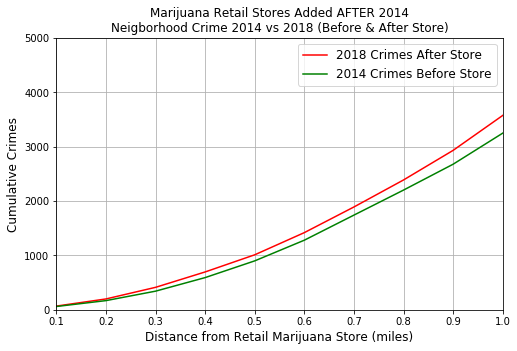

In [54]:
# Cell 53
# plot the 2014 crimes vs 2018 crimes by distance from post-14 stores to visually see changes around the neigborhood

plt.figure(figsize=(8,5))

plt.plot(x_axis, crime18xstore1516_distance_mean, color="red", label="2018 Crimes After Store" )
plt.plot(x_axis, crime14xstore1516_distance_mean, color="green", label="2014 Crimes Before Store" )

plt.xlabel("Distance from Retail Marijuana Store (miles)", fontsize="large")
plt.ylabel("Cumulative Crimes", fontsize="large")

plt.ylim(0,5000)
plt.xlim(0,9)

plt.grid()

plt.title("Marijuana Retail Stores Added AFTER 2014\nNeigborhood Crime 2014 vs 2018 (Before & After Store)", fontsize="large")

plt.legend(loc="best", fontsize="large", fancybox=True)

plt.savefig("Outputs/Post-2014/Marijuana Retail Stores Added AFTER 2014 - Neigborhood Crime 2014 vs 2018.png")

# Show the chart
plt.show()

## Summary Dataframe for Post-14 Stores: Mean Distance to Crimes & % Change in Crime

In [55]:
# Cell 54 
# generate lists with BFN, Entity Name, Lat, Lng
Business_File_Number = denver_retail_licenses_df_2015_16["Business File Number"].tolist()
Entity_Name = denver_retail_licenses_df_2015_16["Entity Name"].tolist()
Lat = denver_retail_licenses_df_2015_16["Lat"].tolist()
Lng = denver_retail_licenses_df_2015_16["Lng"].tolist()

In [56]:
# Cell 55
# generate lists with 2014 and 2018 crimes
Crimes_2014 = distance_crime14xstore1516_plot_df["0.3"].tolist()
Crimes_2018 = distance_crime18xstore1516_plot_df["0.3"].tolist()

In [57]:
# Cell 56
# create a summary dataframe

stores_licensed_after_2014 = pd.DataFrame({"Business File Number": Business_File_Number,
                                           "Entity Name": Entity_Name,
                                           "Lat": Lat,
                                           "Lng": Lng,
                                           "2014 Crimes": Crimes_2014,
                                           "2018 Crimes": Crimes_2018})

In [58]:
# Cell 57
# calculate % change in 2018 crimes vs 2014 crimes and add the data as a new column to the summary dataframe
stores_licensed_after_2014['% Change'] = ((stores_licensed_after_2014['2018 Crimes'] - stores_licensed_after_2014['2014 Crimes']) / stores_licensed_after_2014['2014 Crimes']) * 100

In [59]:
# Cell 58
# display the summary dataframe for inspection
stores_licensed_after_2014.head()

,Business File Number,Entity Name,Lat,Lng,2014 Crimes,2018 Crimes,% Change
0,2015-BFN-0000507,"GREEN AROUND YOU, LLC",39.698796,-104.907221,482,591,22.614108
1,2016-BFN-0004024,"LEVELS IV, INC",39.784036,-105.053573,90,77,-14.444444
2,2015-BFN-0007821,"ROYAL ASSET MANAGEMENT, LLC",39.711487,-105.024465,816,838,2.696078
3,2016-BFN-0004033,HOBBY FARMS LLC,39.681867,-104.988104,217,325,49.769585
4,2015-BFN-0001350,PG RETAIL I LLC,39.730085,-104.987078,980,1179,20.306122


In [60]:
# Cell 59
# output dataframe to csv; the csv can be read into Jupyter when needed rather than go through the creation process from scratch

stores_licensed_after_2014.to_csv("Raw_data/stores_licensed_after_2014_and_before-after_crime_within_half_mile.csv",
                  encoding="utf-8", index=False, header=True)

In [61]:
# Cell 60
# Reading-in New Selected Post-2014 Stores CSV created above for future analysis
file_selected_stores = ('Raw_data/stores_licensed_after_2014_and_before-after_crime_within_half_mile.csv')
post_14_selected_stores_df = pd.read_csv(file_selected_stores)
post_14_selected_stores_df = post_14_selected_stores_df.rename(columns = {"% Change" : "Percent Change"})

## Creation of Sample Stores that Were Licensed BEFORE 2014 (aka pre-14 stores)

* There are 83 stores that were licensed in 2013.
* These stores will serve as a sample of stores that were licensed before both crime years (2014 and 2018).
* The pre-14 stores will serve as a comparison to the post-14 stores that were licensed after the 2014 crime year.

In [62]:
# Cell 61
# filter the Denver store dataframe for stores that were licensed in 2013 (aka pre-14 stores)
denver_retail_licenses_df_2013 = denver_retail_licenses_df_final.loc[denver_retail_licenses_df_final["Year"] == "2013"]

In [63]:
# Cell 62
# check store count
denver_retail_licenses_df_2013["Year"].count()

83

# Collect "Before and After" Crime Activity for Stores Licensed Before 2014

## Stores Licensed BEFORE 2014

## 2014 Crime

In [64]:
# Cell 63
# create a new 2014 crime dataframe that will be populated with distances from the pre-14 stores

crime14xstore2013_all_df = crime14_all_df[['INCIDENT ID','OFFENSE CODE','OFFENSE CATEGORY ID','GEO LON','GEO LAT','DISTRICT ID','YEAR']]
crime14xstore2013_all_df.head()

,INCIDENT ID,OFFENSE CODE,OFFENSE CATEGORY ID,GEO LON,GEO LAT,DISTRICT ID,YEAR
18978,2014478770,5441,traffic-accident,-104.973130,39.674578,3,2014
51768,2014125067,1315,aggravated-assault,-105.025426,39.755872,1,2014
51769,2014125081,2399,larceny,-104.990215,39.751720,6,2014
51770,2014125098,5441,traffic-accident,-105.052572,39.728345,1,2014
51771,2014125111,5441,traffic-accident,-105.014047,39.736908,1,2014


### WARNING: The nested loops in the next cell can take 10+ minutes to execute and perhaps much longer.

#### Execution time will depend on the number of crime years and stores involved in the build.

In [65]:
# Cell 64
# nested for loops compute distance from each store to each crime

# the first loop calls each store
for index, row in denver_retail_licenses_df_2013.iterrows():
    store_location = (row['Lat'], row['Lng'])
    store_num_list = []
    store_num_list.append(row['Business File Number'])
    distance_list = []

    # the second loop calls each crime
    for index, row in crime14xstore2013_all_df.iterrows():
        crime_location = (row['GEO LAT'], row['GEO LON'])
        distance = haversine(store_location, crime_location, unit='mi')
        distance_list.append(distance)
        
    # print(distance_list)   # for testing, output distance lists, comment out
    
    # create new column in test crime dataframe with Store ID as the column header and value as the distance from store to crimes
    crime14xstore2013_all_df[str(store_num_list[0])] = distance_list
    crime14xstore2013_all_df[str(store_num_list[0])] = crime14xstore2013_all_df[str(store_num_list[0])].astype(float)
    
 

C:\Users\samew\Anaconda3\envs\geonew\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\samew\Anaconda3\envs\geonew\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [66]:
# Cell 65
# display dataframe for inspection
crime14xstore2013_all_df.head()

,INCIDENT ID,OFFENSE CODE,OFFENSE CATEGORY ID,GEO LON,GEO LAT,DISTRICT ID,YEAR,2013-BFN-1069798,2013-BFN-1069518,2013-BFN-1069782,...,2013-BFN-1069078,2013-BFN-1068869,2013-BFN-1069018,2013-BFN-1070079,2013-BFN-1069081,2013-BFN-1069409,2013-BFN-1069633,2013-BFN-1069051,2013-BFN-1069170,2013-BFN-1070063
18978,2014478770,5441,traffic-accident,-104.973130,39.674578,3,2014,3.032117,3.126830,7.621400,...,0.783050,7.121913,3.416251,1.653716,4.159366,4.845213,1.492873,4.513489,1.049686,0.755402
51768,2014125067,1315,aggravated-assault,-105.025426,39.755872,1,2014,3.344647,7.943532,5.048796,...,5.888614,3.305848,8.193238,5.312768,3.537968,2.084826,4.837709,3.177666,5.287676,5.911543
51769,2014125081,2399,larceny,-104.990215,39.751720,6,2014,2.405733,6.448166,3.515541,...,5.252958,2.087703,6.669532,4.092455,4.123684,0.565441,4.203988,1.378839,4.598507,5.268481
51770,2014125098,5441,traffic-accident,-105.052572,39.728345,1,2014,3.520210,8.096236,7.176927,...,5.008584,5.553371,8.381983,5.310765,1.690029,3.506849,4.149630,4.492059,4.576627,5.037493
51771,2014125111,5441,traffic-accident,-105.014047,39.736908,1,2014,1.953752,6.640840,5.141380,...,4.452580,3.659589,6.903476,3.936862,2.546388,1.377464,3.397368,2.382792,3.846125,4.474967


In [67]:
# Cell 66
# output dataframe to csv; the csv can be read into Jupyter when needed rather than go through the creation process from scratch
crime14xstore2013_all_df.to_csv("Raw_data/crime14xstore2013_all_df.csv",
                  encoding="utf-8", index=False, header=True)

In [68]:
# Cell 67
# create a new dataframe with only the store-to-crime distances; df will be used to count crimes by distance categories
distance_crime14xstore2013_all = crime14xstore2013_all_df.iloc[:,7:]

distance_crime14xstore2013_all.head()

,2013-BFN-1069798,2013-BFN-1069518,2013-BFN-1069782,2013-BFN-1070236,2013-BFN-1069587,2013-BFN-1069019,2013-BFN-1069359,2013-BFN-1069527,2013-BFN-1069382,2013-BFN-1068991,...,2013-BFN-1069078,2013-BFN-1068869,2013-BFN-1069018,2013-BFN-1070079,2013-BFN-1069081,2013-BFN-1069409,2013-BFN-1069633,2013-BFN-1069051,2013-BFN-1069170,2013-BFN-1070063
18978,3.032117,3.126830,7.621400,9.482736,7.028169,2.899092,1.830208,5.717970,5.362454,1.810215,...,0.783050,7.121913,3.416251,1.653716,4.159366,4.845213,1.492873,4.513489,1.049686,0.755402
51768,3.344647,7.943532,5.048796,9.443856,0.970023,4.664974,4.602388,8.643586,5.771992,7.667946,...,5.888614,3.305848,8.193238,5.312768,3.537968,2.084826,4.837709,3.177666,5.287676,5.911543
51769,2.405733,6.448166,3.515541,7.643371,2.035410,4.744468,4.107769,6.818619,3.881926,6.482565,...,5.252958,2.087703,6.669532,4.092455,4.123684,0.565441,4.203988,1.378839,4.598507,5.268481
51770,3.520210,8.096236,7.176927,11.247130,3.303803,3.136840,3.795253,9.540615,7.154924,7.334821,...,5.008584,5.553371,8.381983,5.310765,1.690029,3.506849,4.149630,4.492059,4.576627,5.037493
51771,1.953752,6.640840,5.141380,9.116311,2.277392,3.401286,3.173074,7.650937,5.066886,6.257888,...,4.452580,3.659589,6.903476,3.936862,2.546388,1.377464,3.397368,2.382792,3.846125,4.474967


In [69]:
# Cell 68
# count crimes by distance categories

count_0_1 = distance_crime14xstore2013_all[distance_crime14xstore2013_all <= 0.1].count()
count_1_2 = distance_crime14xstore2013_all[distance_crime14xstore2013_all <= 0.2].count()
count_2_3 = distance_crime14xstore2013_all[distance_crime14xstore2013_all <= 0.3].count()
count_3_4 = distance_crime14xstore2013_all[distance_crime14xstore2013_all <= 0.4].count()
count_4_5 = distance_crime14xstore2013_all[distance_crime14xstore2013_all <= 0.5].count()
count_5_6 = distance_crime14xstore2013_all[distance_crime14xstore2013_all <= 0.6].count()
count_6_7 = distance_crime14xstore2013_all[distance_crime14xstore2013_all <= 0.7].count()
count_7_8 = distance_crime14xstore2013_all[distance_crime14xstore2013_all <= 0.8].count()
count_8_9 = distance_crime14xstore2013_all[distance_crime14xstore2013_all <= 0.9].count()
count_9_10 = distance_crime14xstore2013_all[distance_crime14xstore2013_all <= 1.0].count()
count_10_11 = distance_crime14xstore2013_all[distance_crime14xstore2013_all <= 1.1].count()
count_11_12 = distance_crime14xstore2013_all[distance_crime14xstore2013_all <= 1.2].count()
count_12_13 = distance_crime14xstore2013_all[distance_crime14xstore2013_all <= 1.3].count()
count_13_14 = distance_crime14xstore2013_all[distance_crime14xstore2013_all <= 1.4].count()
count_14_15 = distance_crime14xstore2013_all[distance_crime14xstore2013_all <= 1.5].count()


In [70]:
# Cell 69
# Create new variable consisting of the 'Store File Numbers' (store ids) to be used as a column with the distance data

Business_File_Number_crime14xstore2013 = distance_crime14xstore2013_all.columns

In [71]:
# Cell 70
# create summary dataframe with crime counts by store by distance category
# this is the dataframe that will be used to compile data for plotting

distance_crime14xstore2013_plot_df = pd.DataFrame({"Business File Number": Business_File_Number_crime14xstore2013,
                                                "0.1": count_0_1,
                                                "0.2": count_1_2,
                                                "0.3": count_2_3,
                                                "0.4": count_3_4,
                                                "0.5": count_4_5,
                                                "0.6": count_5_6,
                                                "0.7": count_6_7,
                                                "0.8": count_7_8,
                                                "0.9": count_8_9,
                                                "1.0": count_9_10,
                                                "1.1": count_10_11,
                                                "1.2": count_11_12,
                                                "1.3": count_12_13,
                                                "1.4": count_13_14,
                                                "1.5": count_14_15})

In [72]:
# Cell 71
# reindex and drop the BFN index

distance_crime14xstore2013_plot_df.reset_index(drop=True)

,Business File Number,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5
0,2013-BFN-1069798,138,355,589,873,1412,1941,2621,3646,4260,4792,5574,6183,6999,7699,9201
1,2013-BFN-1069518,75,133,239,398,523,583,658,783,891,1061,1318,1503,1751,2098,2739
2,2013-BFN-1069782,8,9,162,193,229,289,434,656,745,989,1223,1493,1806,2092,2356
3,2013-BFN-1070236,19,306,471,615,672,755,1065,1255,1387,1692,1797,1884,2039,2188,2439
4,2013-BFN-1069587,33,107,294,434,622,945,1327,1697,2162,2794,3753,4271,5107,5847,6585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,2013-BFN-1069409,293,1380,3153,4235,5695,7426,9492,11801,13303,14602,15939,17411,18478,19752,20929
79,2013-BFN-1069633,38,100,274,518,703,836,1091,1475,1823,2373,2730,3348,3714,4403,5262
80,2013-BFN-1069051,258,867,1520,2160,2804,3731,4760,5750,6544,7800,9092,10396,12336,14719,16472
81,2013-BFN-1069170,23,131,226,383,595,865,1098,1426,1790,2081,2409,2890,3258,3636,4096


In [73]:
# Cell 72
# output dataframe to csv; the csv can be read into Jupyter when needed rather than go through the creation process from scratch
distance_crime14xstore2013_plot_df.to_csv("Raw_data/distance_crime14xstore2013_plot_df.csv",
                  encoding="utf-8", index=False, header=True)

In [74]:
# Cell 73
# calculate the mean distance for the post-14 stores to 2014 crimes; this will be the 2014 crime plot data
crime14xstore2013_distance_mean = distance_crime14xstore2013_plot_df.mean()

crime14xstore2013_distance_mean

0.1      92.481928
0.2     296.349398
0.3     570.855422
0.4     897.048193
0.5    1291.469880
0.6    1779.578313
0.7    2342.759036
0.8    2933.120482
0.9    3542.253012
1.0    4181.518072
1.1    4907.168675
1.2    5647.337349
1.3    6443.265060
1.4    7257.301205
1.5    8161.698795
dtype: float64

## Stores Licensed BEFORE 2014

## 2018 Crime

In [75]:
# Cell 74
# create a new 2018 crime dataframe that will be populated with distances from the pre-14 stores
crime18xstore2013_all_df = crime18_all_df[['INCIDENT ID','OFFENSE CODE','OFFENSE CATEGORY ID','GEO LON','GEO LAT','DISTRICT ID','YEAR']]
crime18xstore2013_all_df.head()

,INCIDENT ID,OFFENSE CODE,OFFENSE CATEGORY ID,GEO LON,GEO LAT,DISTRICT ID,YEAR
1,20186000994,2399,larceny,-104.781434,39.785649,5,2018
3,201872333,2399,larceny,-104.941440,39.702698,3,2018
5,201872837,5499,all-other-crimes,-104.961928,39.743149,6,2018
6,20186001015,2304,theft-from-motor-vehicle,-105.025543,39.732790,1,2018
7,201870628,5707,all-other-crimes,-104.983794,39.723424,3,2018


### WARNING: The nested loops in the next cell can take 10+ minutes to execute and perhaps much longer.

#### Execution time will depend on the number of crime years and stores involved in the build.

In [76]:
# Cell 75
# nested for loops compute distance from each store to each crime

# the first loop calls each store
for index, row in denver_retail_licenses_df_2013.iterrows():
    store_location = (row['Lat'], row['Lng'])
    store_num_list = []
    store_num_list.append(row['Business File Number'])
    distance_list = []

    # the second loop calls each crime
    for index, row in crime18xstore2013_all_df.iterrows():
        crime_location = (row['GEO LAT'], row['GEO LON'])
        distance = haversine(store_location, crime_location, unit='mi')
        distance_list.append(distance)
        
    # print(distance_list)   # for testing, output distance lists, comment out
    
    # create new column in test crime dataframe with Store ID as the column header and value as the distance from store to crimes
    crime18xstore2013_all_df[str(store_num_list[0])] = distance_list
    crime18xstore2013_all_df[str(store_num_list[0])] = crime18xstore2013_all_df[str(store_num_list[0])].astype(float)
    

C:\Users\samew\Anaconda3\envs\geonew\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\samew\Anaconda3\envs\geonew\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [77]:
# Cell 76
# display dataframe for inspection
crime18xstore2013_all_df.head()

,INCIDENT ID,OFFENSE CODE,OFFENSE CATEGORY ID,GEO LON,GEO LAT,DISTRICT ID,YEAR,2013-BFN-1069798,2013-BFN-1069518,2013-BFN-1069782,...,2013-BFN-1069078,2013-BFN-1068869,2013-BFN-1069018,2013-BFN-1070079,2013-BFN-1069081,2013-BFN-1069409,2013-BFN-1069633,2013-BFN-1069051,2013-BFN-1069170,2013-BFN-1070063
1,20186000994,2399,larceny,-104.781434,39.785649,5,2018,11.956409,10.227773,8.225347,...,13.338489,10.026934,10.059916,11.366925,14.797342,11.432161,12.942214,10.471085,12.951406,13.325288
3,201872333,2399,larceny,-104.941440,39.702698,3,2018,2.663913,2.185706,5.429129,...,3.089671,5.394643,2.419491,1.141100,5.240590,3.810201,2.786330,2.964308,2.718365,3.077695
5,201872837,5499,all-other-crimes,-104.961928,39.743149,6,2018,2.280308,5.111990,2.960358,...,4.857611,2.420288,5.300901,3.204692,4.879617,1.470466,3.939509,0.456407,4.223580,4.864447
6,20186001015,2304,theft-from-motor-vehicle,-105.025543,39.732790,1,2018,2.275251,6.980809,5.803092,...,4.424996,4.278524,7.254159,4.217799,2.009457,2.049174,3.412930,3.024480,3.867266,4.450199
7,201870628,5707,all-other-crimes,-104.983794,39.723424,3,2018,0.500783,4.802644,4.722528,...,3.303098,3.816235,5.059053,2.190733,3.220375,1.424393,2.285817,1.369095,2.647053,3.316300


In [78]:
# Cell 77
# output dataframe to csv; the csv can be read into Jupyter when needed rather than go through the creation process from scratch

crime18xstore2013_all_df.to_csv("Raw_data/crime18xstore2013_all_df.csv",
                  encoding="utf-8", index=False, header=True)

In [79]:
# Cell 78
# create a new dataframe with only the store-to-crime distances; df will be used to count crimes by distance categories

distance_crime18xstore2013_all = crime18xstore2013_all_df.iloc[:,7:]

distance_crime18xstore2013_all.head()

,2013-BFN-1069798,2013-BFN-1069518,2013-BFN-1069782,2013-BFN-1070236,2013-BFN-1069587,2013-BFN-1069019,2013-BFN-1069359,2013-BFN-1069527,2013-BFN-1069382,2013-BFN-1068991,...,2013-BFN-1069078,2013-BFN-1068869,2013-BFN-1069018,2013-BFN-1070079,2013-BFN-1069081,2013-BFN-1069409,2013-BFN-1069633,2013-BFN-1069051,2013-BFN-1069170,2013-BFN-1070063
1,11.956409,10.227773,8.225347,3.691648,12.760300,14.565222,13.197177,7.293872,7.947785,11.850091,...,13.338489,10.026934,10.059916,11.366925,14.797342,11.432161,12.942214,10.471085,12.951406,13.325288
3,2.663913,2.185706,5.429129,6.916166,6.249893,4.532108,3.105317,3.556040,2.842412,2.545025,...,3.089671,5.394643,2.419491,1.141100,5.240590,3.810201,2.786330,2.964308,2.718365,3.077695
5,2.280308,5.111990,2.960358,6.345299,3.617559,5.043372,3.993487,5.210051,2.303860,5.454180,...,4.857611,2.420288,5.300901,3.204692,4.879617,1.470466,3.939509,0.456407,4.223580,4.864447
6,2.275251,6.980809,5.803092,9.782468,2.545795,3.070373,3.130436,8.179481,5.694993,6.447292,...,4.424996,4.278524,7.254159,4.217799,2.009457,2.049174,3.412930,3.024480,3.867266,4.450199
7,0.500783,4.802644,4.722528,7.941835,3.739441,3.252803,2.266167,5.877971,3.639386,4.580940,...,3.303098,3.816235,5.059053,2.190733,3.220375,1.424393,2.285817,1.369095,2.647053,3.316300


In [80]:
# Cell 79
# count crimes by distance categories

count_0_1 = distance_crime18xstore2013_all[distance_crime18xstore2013_all <= 0.1].count()
count_1_2 = distance_crime18xstore2013_all[distance_crime18xstore2013_all <= 0.2].count()
count_2_3 = distance_crime18xstore2013_all[distance_crime18xstore2013_all <= 0.3].count()
count_3_4 = distance_crime18xstore2013_all[distance_crime18xstore2013_all <= 0.4].count()
count_4_5 = distance_crime18xstore2013_all[distance_crime18xstore2013_all <= 0.5].count()
count_5_6 = distance_crime18xstore2013_all[distance_crime18xstore2013_all <= 0.6].count()
count_6_7 = distance_crime18xstore2013_all[distance_crime18xstore2013_all <= 0.7].count()
count_7_8 = distance_crime18xstore2013_all[distance_crime18xstore2013_all <= 0.8].count()
count_8_9 = distance_crime18xstore2013_all[distance_crime18xstore2013_all <= 0.9].count()
count_9_10 = distance_crime18xstore2013_all[distance_crime18xstore2013_all <= 1.0].count()
count_10_11 = distance_crime18xstore2013_all[distance_crime18xstore2013_all <= 1.1].count()
count_11_12 = distance_crime18xstore2013_all[distance_crime18xstore2013_all <= 1.2].count()
count_12_13 = distance_crime18xstore2013_all[distance_crime18xstore2013_all <= 1.3].count()
count_13_14 = distance_crime18xstore2013_all[distance_crime18xstore2013_all <= 1.4].count()
count_14_15 = distance_crime18xstore2013_all[distance_crime18xstore2013_all <= 1.5].count()


In [81]:
# Cell 80
# Create new variable consisting of the 'Store File Numbers' (store ids) to be used as a column with the distance data

Business_File_Number_crime18xstore2013 = distance_crime18xstore2013_all.columns

In [82]:
# Cell 81
# create summary dataframe with crime counts by store by distance category
# this is the dataframe that will be used to compile data for plotting

distance_crime18xstore2013_plot_df = pd.DataFrame({"Business File Number": Business_File_Number_crime18xstore2013,
                                                "0.1": count_0_1,
                                                "0.2": count_1_2,
                                                "0.3": count_2_3,
                                                "0.4": count_3_4,
                                                "0.5": count_4_5,
                                                "0.6": count_5_6,
                                                "0.7": count_6_7,
                                                "0.8": count_7_8,
                                                "0.9": count_8_9,
                                                "1.0": count_9_10,
                                                "1.1": count_10_11,
                                                "1.2": count_11_12,
                                                "1.3": count_12_13,
                                                "1.4": count_13_14,
                                                "1.5": count_14_15})

In [83]:
# Cell 82
# reindex and drop the BFN index
distance_crime14xstore2013_plot_df.reset_index(drop=True)

,Business File Number,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5
0,2013-BFN-1069798,138,355,589,873,1412,1941,2621,3646,4260,4792,5574,6183,6999,7699,9201
1,2013-BFN-1069518,75,133,239,398,523,583,658,783,891,1061,1318,1503,1751,2098,2739
2,2013-BFN-1069782,8,9,162,193,229,289,434,656,745,989,1223,1493,1806,2092,2356
3,2013-BFN-1070236,19,306,471,615,672,755,1065,1255,1387,1692,1797,1884,2039,2188,2439
4,2013-BFN-1069587,33,107,294,434,622,945,1327,1697,2162,2794,3753,4271,5107,5847,6585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,2013-BFN-1069409,293,1380,3153,4235,5695,7426,9492,11801,13303,14602,15939,17411,18478,19752,20929
79,2013-BFN-1069633,38,100,274,518,703,836,1091,1475,1823,2373,2730,3348,3714,4403,5262
80,2013-BFN-1069051,258,867,1520,2160,2804,3731,4760,5750,6544,7800,9092,10396,12336,14719,16472
81,2013-BFN-1069170,23,131,226,383,595,865,1098,1426,1790,2081,2409,2890,3258,3636,4096


In [84]:
# Cell 83
# output dataframe to csv; the csv can be read into Jupyter when needed rather than go through the creation process from scratch
distance_crime18xstore2013_plot_df.to_csv("Raw_data/distance_crime18xstore2013_plot_df.csv",
                  encoding="utf-8", index=False, header=True)

In [85]:
# Cell 84
# calculate the mean distance for the post-14 stores to 2014 crimes; this will be the 2014 crime plot data

crime18xstore2013_distance_mean = distance_crime18xstore2013_plot_df.mean()

crime18xstore2013_distance_mean

0.1      96.855422
0.2     319.325301
0.3     631.096386
0.4     996.337349
0.5    1448.156627
0.6    1984.084337
0.7    2591.421687
0.8    3237.012048
0.9    3925.987952
1.0    4627.554217
1.1    5458.481928
1.2    6296.506024
1.3    7143.867470
1.4    8021.987952
1.5    8970.602410
dtype: float64

## Plot of 2014 vs. 2018 crimes by distance from store licensed BEFORE 2014

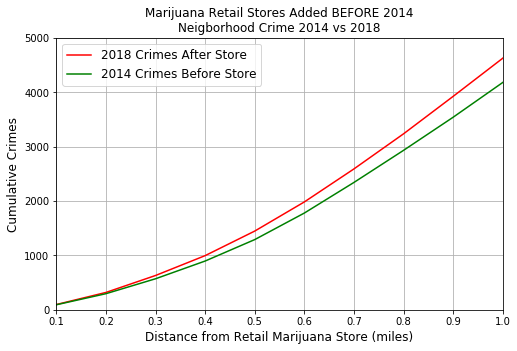

In [86]:
# Cell 85
# plot the 2014 crimes vs 2018 crimes by distance from pre-14 stores to visually see changes around the neigborhood

plt.figure(figsize=(8,5))

plt.plot(x_axis, crime18xstore2013_distance_mean, color="red", label="2018 Crimes After Store" )
plt.plot(x_axis, crime14xstore2013_distance_mean, color="green", label="2014 Crimes Before Store" )

plt.xlabel("Distance from Retail Marijuana Store (miles)", fontsize="large")
plt.ylabel("Cumulative Crimes", fontsize="large")

plt.ylim(0,5000)
plt.xlim(0,9)


plt.grid()

plt.title("Marijuana Retail Stores Added BEFORE 2014\nNeigborhood Crime 2014 vs 2018", fontsize="large")

plt.legend(loc="best", fontsize="large", fancybox=True)

plt.savefig("Outputs/Pre-2014/Marijuana Retail Stores Added BEFORE 2014 - Neigborhood Crime 2014 vs 2018.png")

# Show the chart
plt.show()

## Summary Dataframe for Pre-14 Stores: Mean Distance to Crimes & % Change in Crime

In [87]:
# Cell 86
# generate lists with BFN, Entity Name, Lat, Lng

Business_File_Number_before_2014 = denver_retail_licenses_df_2013["Business File Number"].tolist()
Entity_Name_before_2014 = denver_retail_licenses_df_2013["Entity Name"].tolist()
Lat_before_2014 = denver_retail_licenses_df_2013["Lat"].tolist()
Lng_before_2014 = denver_retail_licenses_df_2013["Lng"].tolist()

In [88]:
# Cell 87
# generate lists with 2014 and 2018 crimes

Crimes_2014_before_2014 = distance_crime14xstore2013_plot_df["0.3"].tolist()
Crimes_2018_before_2014 = distance_crime18xstore2013_plot_df["0.3"].tolist()

In [89]:
# Cell 88
# create a summary dataframe

stores_licensed_before_2014 = pd.DataFrame({"Business File Number": Business_File_Number_before_2014,
                                           "Entity Name": Entity_Name_before_2014,
                                           "Lat": Lat_before_2014,
                                           "Lng": Lng_before_2014,
                                           "2014 Crimes": Crimes_2014_before_2014,
                                           "2018 Crimes": Crimes_2018_before_2014})

In [90]:
# Cell 89
# calculate % change in 2018 crimes vs 2014 crimes and add the data as a new column to the summary dataframe

stores_licensed_before_2014['% Change'] = ((stores_licensed_before_2014['2018 Crimes'] - stores_licensed_before_2014['2014 Crimes']) / stores_licensed_before_2014['2014 Crimes']) * 100

In [91]:
# Cell 90
# display the summary dataframe for inspection
stores_licensed_before_2014.head()

,Business File Number,Entity Name,Lat,Lng,2014 Crimes,2018 Crimes,% Change
0,2013-BFN-1069798,"ARES STRATEGIES, INC",39.716942,-104.988012,589,565,-4.074703
1,2013-BFN-1069518,"MEDICINAL WELLNESS CENTER, LLC",39.678749,-104.914581,239,322,34.728033
2,2013-BFN-1069782,DELTA-9 DELIGHTS LLC,39.781173,-104.936239,162,236,45.679012
3,2013-BFN-1070236,"COLORADO FARMS, INC",39.773210,-104.849047,471,765,62.420382
4,2013-BFN-1069587,"THE GIVING TREE OF DENVER, LLC",39.769456,-105.020813,294,284,-3.401361


In [92]:
# Cell 91
# output dataframe to csv; the csv can be read into Jupyter when needed rather than go through the creation process from scratch

stores_licensed_before_2014.to_csv("Raw_data/stores_licensed_before_2014_and_2014v2018_crime_within_half_mile.csv",
                  encoding="utf-8", index=False, header=True)

In [93]:
# Cell 92
# Reading-in new Selected Pre-2014 Stores CSV created above for future use
file_pre14_selected_stores = ('Raw_data/stores_licensed_before_2014_and_before-after_crime_within_half_mile.csv')
pre_14_selected_stores_df = pd.read_csv(file_pre14_selected_stores)
pre_14_selected_stores_df = pre_14_selected_stores_df.rename(columns = {"% Change" : "Percent Change"})


# Data and Plotting to Compare Crime Rate % Change

## Stores Licensing Before 2014 and Stores Licensing After 2014

In [94]:
# Cell 93
# send distance points to list
distance_from_store = x_axis.tolist()

# create dataframe with required data for stores licensing AFTER 2014
store1516_distance_means_2018v2014 = pd.DataFrame({"distance_from_store_(miles)": distance_from_store,
                                                "2014_crimes_mean": crime14xstore1516_distance_mean,
                                                "2018_crimes_mean": crime18xstore1516_distance_mean})

In [95]:
# Cell 94
# calculate % change in 2018 crimes vs 2014 crimes and add the data as a new column to the summary dataframe

store1516_distance_means_2018v2014['% Change'] = ((store1516_distance_means_2018v2014['2018_crimes_mean'] - store1516_distance_means_2018v2014['2014_crimes_mean']) / store1516_distance_means_2018v2014['2014_crimes_mean']) * 100

In [96]:
# Cell 95
# display for inspection
store1516_distance_means_2018v2014.head()

,distance_from_store_(miles),2014_crimes_mean,2018_crimes_mean,% Change
0.1,0.1,60.545455,68.212121,12.662663
0.2,0.2,168.848485,199.515152,18.162240
0.3,0.3,342.727273,413.060606,20.521662
0.4,0.4,592.363636,696.303030,17.546552
0.5,0.5,900.060606,1011.787879,12.413306


In [97]:
# Cell 96
# send distance points to list
distance_from_store = x_axis.tolist()

# create dataframe with required data for stores licensing BEFORE 2014
store2013_distance_means_2018v2014 = pd.DataFrame({"distance_from_store_(miles)": distance_from_store,
                                                "2014_crimes_mean": crime14xstore2013_distance_mean,
                                                "2018_crimes_mean": crime18xstore2013_distance_mean})

In [98]:
# Cell 97
# calculate % change in 2018 crimes vs 2014 crimes and add the data as a new column to the summary dataframe

store2013_distance_means_2018v2014['% Change'] = ((store2013_distance_means_2018v2014['2018_crimes_mean'] - store2013_distance_means_2018v2014['2014_crimes_mean']) / store2013_distance_means_2018v2014['2014_crimes_mean']) * 100

In [99]:
# Cell 98
# display for inspection
store2013_distance_means_2018v2014.head()

,distance_from_store_(miles),2014_crimes_mean,2018_crimes_mean,% Change
0.1,0.1,92.481928,96.855422,4.729026
0.2,0.2,296.349398,319.325301,7.752978
0.3,0.3,570.855422,631.096386,10.552753
0.4,0.4,897.048193,996.337349,11.068431
0.5,0.5,1291.469880,1448.156627,12.132435


In [100]:
# Cell 99
# create y_axis data to plot
post2014_crime_change_rate = store1516_distance_means_2018v2014['% Change'].tolist()
pre2014_crime_change_rate = store2013_distance_means_2018v2014['% Change'].tolist()

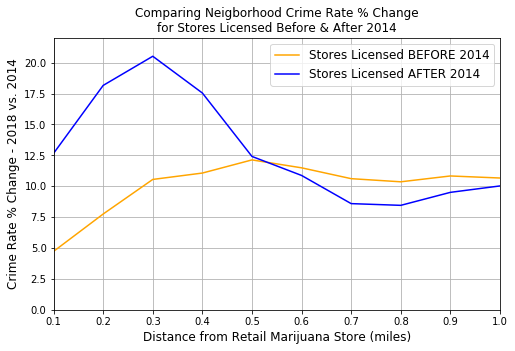

In [101]:
# Cell 100
# plot the 2014 crimes vs 2018 crimes by distance from pre-14 stores to visually see changes around the neigborhood

plt.figure(figsize=(8,5))

plt.plot(x_axis, pre2014_crime_change_rate, color="orange", label="Stores Licensed BEFORE 2014")
plt.plot(x_axis, post2014_crime_change_rate, color="blue", label="Stores Licensed AFTER 2014" )

plt.xlabel("Distance from Retail Marijuana Store (miles)", fontsize="large")
plt.ylabel("Crime Rate % Change - 2018 vs. 2014", fontsize="large")

plt.ylim(0,22)
plt.xlim(0,9)


plt.grid()

plt.title("Comparing Neigborhood Crime Rate % Change\nfor Stores Licensed Before & After 2014", fontsize="large")

plt.legend(loc="best", fontsize="large", fancybox=True)

plt.savefig("Outputs/Comparing Neigborhood Crime Rate % Change.png")

# Show the chart
plt.show()

# Data and Plotting For Big Picture Crime Incidence per 100,000 People

* Population data uses 2010 US Census as a base for further estimates;  source: [live population](http://livepopulationof.com/population-of-denver/)

* Crime data is the data used for this study;  source: [kaggle](https://www.kaggle.com/paultimothymooney/denver-crime-data)

In [102]:
# Cell 101
# count crime incidents by year (2019 is incomplete)
crime_all_df['YEAR'].value_counts()

2018    93524
2017    93208
2016    91397
2015    89171
2014    82297
2019    68896
Name: YEAR, dtype: int64

In [103]:
# cell 102
# create dataframe from dictionary of lists with year, population, crime incidents, crime per 100k people
crime_per_100k_df = pd.DataFrame(
    {"Year": ["2014", "2015", "2016", "2017", "2018"],
     "Population": [663862, 682545, 693060, 705214, 716632],
     "Crime Incidents": [82297, 89171, 91397, 93208, 93524],
     "Crime Incidence per 100,000 People": [12397, 13064, 13187, 13217, 13050],
     "Retail Marijuana Stores": [108, 130, 141, 145, 145]
     }
)
crime_per_100k_df

,Year,Population,Crime Incidents,"Crime Incidence per 100,000 People",Retail Marijuana Stores
0,2014,663862,82297,12397,108
1,2015,682545,89171,13064,130
2,2016,693060,91397,13187,141
3,2017,705214,93208,13217,145
4,2018,716632,93524,13050,145


In [104]:
# Cell 103
# generate x_axis and y_axis data
year = crime_per_100k_df['Year'].tolist()
crime_per_100k = crime_per_100k_df['Crime Incidence per 100,000 People'].tolist()
retail_stores = crime_per_100k_df['Retail Marijuana Stores'].tolist()

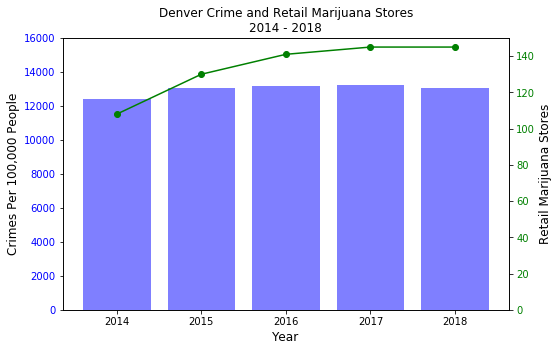

In [105]:
# Cell 104
# bar plot of crime incidents per 100k of people

fig, ax1 = plt.subplots(figsize = (8, 5))

ax1.set_xlabel("Year", fontsize="large")
ax1.set_ylabel("Crimes Per 100,000 People", fontsize="large")
ax1.set_ylim(0,16000)
ax1.bar(year, crime_per_100k, color='b', alpha=0.5, align="center")
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()

ax2.set_ylabel("Retail Marijuana Stores", fontsize="large")
ax2.set_ylim(0,150)
ax2.plot(year, retail_stores, color='g', marker='o')
ax2.tick_params(axis='y', labelcolor='g')


plt.title("Denver Crime and Retail Marijuana Stores\n2014 - 2018", fontsize="large")

plt.savefig("Outputs/Denver Data/Denver Crime and Retail Stores 2014-2018.png")

# Show the chart
plt.show()

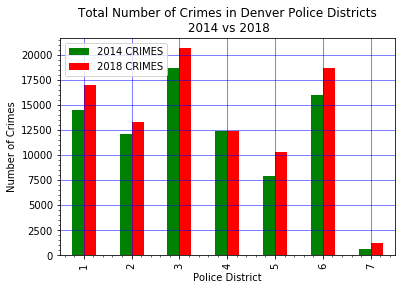

In [106]:
# Cell 105
# Count 2014 Crimes
summary_crime_data_14_df = summary_crime_data_df.loc[summary_crime_data_df["YEAR"] == 2014]
crime_count_2014 = summary_crime_data_14_df.groupby(["DISTRICT ID"])["OFFENSE TYPE ID"].count()
crime_count_2014_df = pd.DataFrame(crime_count_2014)
crime_count_2014_df = crime_count_2014_df.rename(columns = {"OFFENSE TYPE ID" : "2014 CRIMES"})

# Count 2018 Crimes
summary_crime_data_18_df = summary_crime_data_df.loc[summary_crime_data_df["YEAR"] == 2018]
crime_count_2018 = summary_crime_data_18_df.groupby(["DISTRICT ID"])["OFFENSE TYPE ID"].count()
crime_count_2018_df = pd.DataFrame(crime_count_2018)
crime_count_2018_df = crime_count_2018_df.rename(columns = {"OFFENSE TYPE ID" : "2018 CRIMES"})

# Merge 2014 and 2018 Crimes
combined_14_18_crime_count_df = pd.merge(crime_count_2014_df, crime_count_2018_df, how="outer", on="DISTRICT ID")
combined_14_18_crime_count_df


# Graphing 2014/2018 Crimes
combined_14_18_crime_count_df.plot(kind="bar", color = "gr")
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='blue')
plt.title("Total Number of Crimes in Denver Police Districts\n 2014 vs 2018")
plt.xlabel("Police District")
plt.ylabel("Number of Crimes")
plt.savefig("Outputs/Denver Data/2014-2018 Crime Count.png")
plt.show()



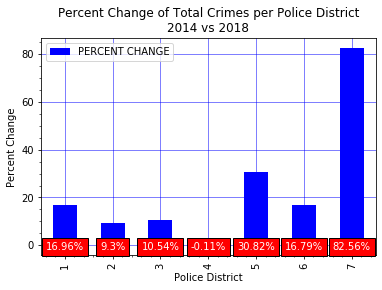

In [107]:
# Cell 106

#Graphing Percent Change of Crime between 2014 - 2018 for each district

percent_change_crime = []

for crimes in combined_14_18_crime_count_df.iterrows():
    crimes_2014 = crimes[1][0]
    crimes_2018 = crimes[1][1]
    percent_change = round((((crimes_2018 - crimes_2014)/crimes_2014)*100),2)
    percent_change_crime.append(percent_change)

combined_14_18_crime_count_df["PERCENT CHANGE"] = percent_change_crime

crime_percent_change_df = combined_14_18_crime_count_df[["PERCENT CHANGE"]]

crime_percent_change_df.plot(kind="bar", color = "blue")
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='blue')
plt.title("Percent Change of Total Crimes per Police District\n2014 vs 2018")
plt.xlabel("Police District")
plt.ylabel("Percent Change")

for district, value in enumerate(percent_change_crime):
    plt.text(district, -2, s=(f'{round(value,2)}%'),horizontalalignment="center",bbox=dict(facecolor='red', alpha=1),color="white")

plt.savefig("Outputs/Denver Data/Percent Change of all Crimes 2014-2018.png")

plt.show()

In [108]:
# Cell 107
# GeoPandas - Read Police District .GeoJSON file for graphing purposes
district_geodata_df = gpd.read_file("Raw_data/police_districts.geojson")

In [109]:
# Cell 108
# Plotting Every Dispensary in the City of Denver on an interactive map, with Police Districts overlaid

# Create list and column to store the police district each dispensary is in
stored_police_districts = []
weed_store_df["Police District"] = ""
# Store Denver's coordinates to help initiate map construction
coord_Den=[39.7392, -104.9903]

# Create Base Map
base_map = folium.Map(
    width='100%', 
    height='100%',
    location=coord_Den,
    zoom_start=11,
)

denver_map = base_map

# Set pop-ups to identify Police District (To identify a police district, simply click on the desired area)
for district in district_geodata_df.iterrows():
    geojson=folium.GeoJson(district[1][3],name='districts').add_to(denver_map)
    popup = folium.Popup(f'District {district[1][0]}')
    popup.add_to(geojson)
    geojson.add_to(denver_map)

# Identify where stores are and plot them
for store in weed_store_df.iterrows():
    coord_DenCrime=[store[1][15], store[1][16]]
    
    folium.Marker(
        location= (coord_DenCrime), 
        popup= store[1][2],
        icon=folium.Icon(color='green', icon='cloud')
    ).add_to(denver_map)
    
    coord_DenCrime.reverse()
    Pt_DenCrime=Point(tuple(coord_DenCrime))
    
# Identify which police district a store's coordinates fall into and record that data
    for i in range(7): 
        if district_geodata_df.geometry[i].contains(Pt_DenCrime):
            stored_police_districts.append(district_geodata_df["DIST_NUM"][i])
        
denver_map.save("Outputs/Denver Data/Denver Dispensaries and Police Districts.html")
denver_map

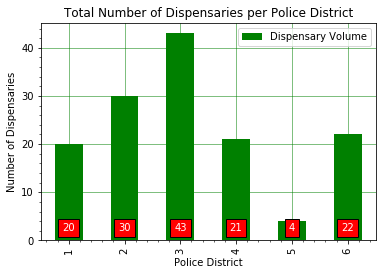

In [110]:
# Cell 109
# Graphing Number of Dispensaries per District

# Storing the number of Dispensaries to be used as labels on the graph
labels = []

# Grouping Dispensaries into Districts, getting counts
weed_store_df["Police District"] = stored_police_districts
weed_store_count = weed_store_df.groupby(["Police District"])["License Type"].count()
stores_per_district_df = pd.DataFrame(weed_store_count)
stores_per_district_df = stores_per_district_df.rename(columns = {"License Type" : "Dispensary Volume"})

# Record values to the list above
for row in stores_per_district_df.iterrows():
    labels.append(row[1][0])

# Graphing Dispensary Volume
stores_per_district_df.plot(kind="bar", color = "green")
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.title("Total Number of Dispensaries per Police District")
plt.xlabel("Police District")
plt.ylabel("Number of Dispensaries")

# Labeler Loop
for district, value in enumerate(labels):
    plt.text(district, 2, s=(f'{round(value,2)}'),horizontalalignment="center",bbox=dict(facecolor='red', alpha=1),color="white")

plt.savefig("Outputs/Denver Data/Dispensaries per District.png")
plt.show()

## PRE-2014 LICENSED STORE ANALYSIS

In [111]:
# Cell 110
# Plotting Every Pre-2014 Licensed Dispensary in the City of Denver on an interactive map, with Police Districts overlaid

# Create list and column to store the police district each dispensary is in
selected_stores_police_districts = []
pre_14_selected_stores_df["Police District"] = ""
coord_Den=[39.7392, -104.9903]

# Create Base Map
base_map = folium.Map(
    width='100%', 
    height='100%',
    location=coord_Den,
    zoom_start=11,
)

denver_map = base_map

# Set pop-ups to identify Police District (To identify a police district, simply click on the desired area)
for district in district_geodata_df.iterrows():
    geojson=folium.GeoJson(district[1][3],name='districts').add_to(denver_map)
    popup = folium.Popup(f'District {district[1][0]}')
    popup.add_to(geojson)
    geojson.add_to(denver_map)

# Identify where stores are and plot them
for store in pre_14_selected_stores_df.iterrows():
    coord_DenCrime=[store[1][2], store[1][3]]
    
    folium.Marker(
        location= (coord_DenCrime), 
        popup= store[1][1],
        icon=folium.Icon(color='green', icon='cloud')
    ).add_to(denver_map)
    
    coord_DenCrime.reverse()
    Pt_DenCrime=Point(tuple(coord_DenCrime))
    
# Identify which police district a store's coordinates fall into and record that data
    for i in range(7): 
        if district_geodata_df.geometry[i].contains(Pt_DenCrime):
            selected_stores_police_districts.append(district_geodata_df["DIST_NUM"][i])
        
denver_map.save("Outputs/Pre-2014/Selected Pre-2014 Dispensaries and Police Districts.html")
denver_map

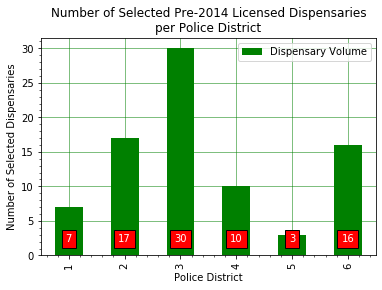

In [112]:
# Cell 111
# Graphing Number of Selected Pre-2014 Licensed Dispensaries per District

# Storing the number of Dispensaries to be used as labels on the graph
labels = []

# Grouping Dispensaries into Districts, getting counts
pre_14_selected_stores_df["Police District"] = selected_stores_police_districts
pre_14_selected_store_count = pre_14_selected_stores_df.groupby(["Police District"])["Business File Number"].count()
pre_14_selected_stores_per_district_df = pd.DataFrame(pre_14_selected_store_count)
pre_14_selected_stores_per_district_df = pre_14_selected_stores_per_district_df.rename(columns = {"Business File Number" : "Dispensary Volume"})

# Record values to the list above for use as labels
for row in pre_14_selected_stores_per_district_df.iterrows():
    labels.append(row[1][0])

# Graphing Dispensary Volume
pre_14_selected_stores_per_district_df.plot(kind="bar", color = "green")
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.title("Number of Selected Pre-2014 Licensed Dispensaries\nper Police District")
plt.xlabel("Police District")
plt.ylabel("Number of Selected Dispensaries")

# Labeler Loop
for district, value in enumerate(labels):
    plt.text(district, 2, s=(f'{round(value,2)}'),horizontalalignment="center",bbox=dict(facecolor='red', alpha=1),color="white")

plt.savefig("Outputs/Pre-2014/Selected Post-2014-licensed Dispensaries per District.png")
plt.show()

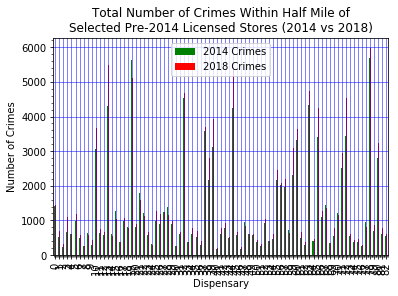

In [113]:
# Cell 112
# Graph Number of Crimes within 0.5 Miles of Selected Pre-2014 Licensed Stores (2014 -2018)
# Create Summary Dataframe for graphing purposes
pre_14_selected_stores_crime_df = pre_14_selected_stores_df[["Business File Number", "2014 Crimes", "2018 Crimes"]]

# Create plot and format as needed
pre_14_selected_stores_crime_df.plot(kind="bar", color = "gr")
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='blue')
plt.title("Total Number of Crimes Within Half Mile of\nSelected Pre-2014 Licensed Stores (2014 vs 2018)")
plt.xlabel("Dispensary")
plt.ylabel("Number of Crimes")
plt.savefig("Outputs/Pre-2014/2014-2018 Crime Count near selected pre-2014 Licensed stores.png")
plt.show()

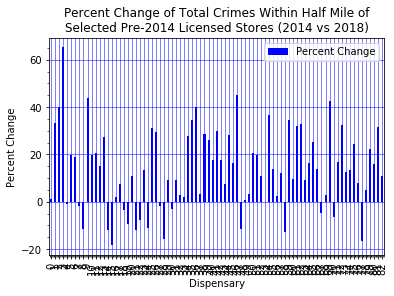

In [114]:
# Cell 113
# Graph Percent Change of Crimes within 0.5 Miles of Selected Pre-2014 Licensed Stores (2014 -2018)
# Create Summary Dataframe for graphing purposes
pre_14_selected_stores_crime_percent_df = pre_14_selected_stores_df[["Business File Number", "Percent Change"]]

# Create plot and format as needed
pre_14_selected_stores_crime_percent_df.plot(kind="bar", color = "blue")
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='blue')
plt.title("Percent Change of Total Crimes Within Half Mile of\nSelected Pre-2014 Licensed Stores (2014 vs 2018)")
plt.xlabel("Dispensary")
plt.ylabel("Percent Change")

plt.savefig("Outputs/Pre-2014/Percent Change of all Crimes 2014-2018 near selected pre-2014 licensed stores.png")

plt.show()

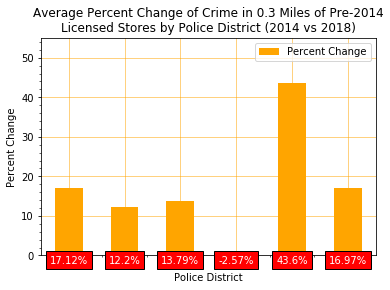

In [115]:
# Cell 114
# Graph Average Percent Change of Crimes within 0.5 Miles of Selected Pre-2014 Licensed Stores (2014 -2018)

# Storing the number of Dispensaries to be used as labels on the graph
labels = []

# Creating summary dataframe for graphing purposes
pre_14_percent_change_analysis = pre_14_selected_stores_df.groupby(["Police District"])["Percent Change"].mean()
pre_14_percent_change_analysis_df = pd.DataFrame(pre_14_percent_change_analysis)

# Record values to the list above for use as labels
for row in pre_14_percent_change_analysis_df.iterrows():
    labels.append(row[1][0])

# Create plot and format as needed
pre_14_percent_change_analysis_df.plot(kind="bar", color = "orange")
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='orange')
plt.title("Average Percent Change of Crime in 0.3 Miles of Pre-2014\nLicensed Stores by Police District (2014 vs 2018)")
plt.xlabel("Police District")
plt.ylabel("Percent Change")
plt.ylim(0,55)

# Labeler Loop
for district, value in enumerate(labels):
    plt.text(district, -2, s=(f'{round(value,2)}%'),horizontalalignment="center",bbox=dict(facecolor='red', alpha=1),color="white")

plt.savefig("Outputs/Pre-2014/REVISED Average Change for Selected Pre-2014-Licensed Dispensaries per District.png")
plt.show()

## POST-2014 LICENSED STORE ANALYSIS

In [116]:
# Cell 115
# Plotting Every Post-2014 Licensed Dispensary in the City of Denver on an interactive map, with Police Districts overlaid

# Create list and column to store the police district each dispensary is in
selected_stores_police_districts = []
post_14_selected_stores_df["Police District"] = ""
coord_Den=[39.7392, -104.9903]

# Create Base Map
base_map = folium.Map(
    width='100%', 
    height='100%',
    location=coord_Den,
    zoom_start=11,
)

denver_map = base_map

# Set pop-ups to identify Police District (To identify a police district, simply click on the desired area)
for district in district_geodata_df.iterrows():
    geojson=folium.GeoJson(district[1][3],name='districts').add_to(denver_map)
    popup = folium.Popup(f'District {district[1][0]}')
    popup.add_to(geojson)
    geojson.add_to(denver_map)

# Identify where stores are and plot them
for store in post_14_selected_stores_df.iterrows():
    coord_DenCrime=[store[1][2], store[1][3]]
    
    folium.Marker(
        location= (coord_DenCrime), 
        popup= store[1][1],
        icon=folium.Icon(color='green', icon='cloud')
    ).add_to(denver_map)
    
    coord_DenCrime.reverse()
    Pt_DenCrime=Point(tuple(coord_DenCrime))
    
# Identify which police district a store's coordinates fall into and record that data
    for i in range(7): 
        if district_geodata_df.geometry[i].contains(Pt_DenCrime):
            selected_stores_police_districts.append(district_geodata_df["DIST_NUM"][i])
        
denver_map.save("Outputs/Post-2014/Selected post-2014 Dispensaries and Police Districts.html")
denver_map

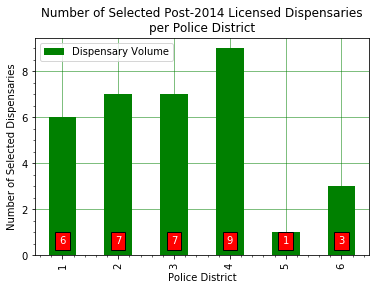

In [117]:
# Cell 116
# Graphing Number of Selected Post-2014 Licensed Dispensaries per District

# Storing the number of Dispensaries to be used as labels on the graph
labels = []

# Grouping Dispensaries into Districts, getting counts
post_14_selected_stores_df["Police District"] = selected_stores_police_districts
post_14_selected_store_count = post_14_selected_stores_df.groupby(["Police District"])["Business File Number"].count()
post_14_selected_stores_per_district_df = pd.DataFrame(post_14_selected_store_count)
post_14_selected_stores_per_district_df = post_14_selected_stores_per_district_df.rename(columns = {"Business File Number" : "Dispensary Volume"})

# Record values to the list above for use as labels
for row in post_14_selected_stores_per_district_df.iterrows():
    labels.append(row[1][0])

# Graphing Dispensary Volume
post_14_selected_stores_per_district_df.plot(kind="bar", color = "green")
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.title("Number of Selected Post-2014 Licensed Dispensaries\nper Police District")
plt.xlabel("Police District")
plt.ylabel("Number of Selected Dispensaries")

# Labeler Loop
for district, value in enumerate(labels):
    plt.text(district, 0.5, s=(f'{round(value,2)}'),horizontalalignment="center",bbox=dict(facecolor='red', alpha=1),color="white")
    
plt.savefig("Outputs/Post-2014/Selected Post-2014-licensed Dispensaries per District.png")
plt.show()

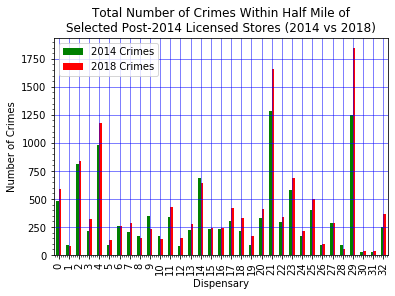

In [118]:
# Cell 117
# Graph Number of Crimes within 0.5 Miles of Selected Post-2014 Licensed Stores (2014 -2018)
# Create Summary Dataframe for graphing purposes
post_14_selected_stores_crime_df = post_14_selected_stores_df[["Business File Number", "2014 Crimes", "2018 Crimes"]]
post_14_selected_stores_crime_df.plot(kind="bar", color = "gr")

# Create plot and format as needed
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='blue')
plt.title("Total Number of Crimes Within Half Mile of\nSelected Post-2014 Licensed Stores (2014 vs 2018)")
plt.xlabel("Dispensary")
plt.ylabel("Number of Crimes")
plt.savefig("Outputs/Post-2014/2014-2018 Crime Count near selected post-2014 Licensed stores.png")
plt.show()

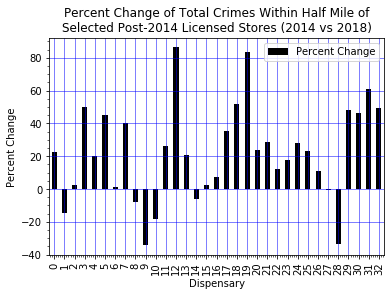

In [119]:
# Cell 118
# Graph Percent Change of Crimes within 0.5 Miles of Selected Post-2014 Licensed Stores (2014 -2018)
# Create Summary Dataframe for graphing purposes
post_14_selected_stores_crime_percent_df = post_14_selected_stores_df[["Business File Number", "Percent Change"]]
post_14_selected_stores_crime_percent_df

# Create plot and format as needed
post_14_selected_stores_crime_percent_df.plot(kind="bar", color = "black")
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='blue')
plt.title("Percent Change of Total Crimes Within Half Mile of\nSelected Post-2014 Licensed Stores (2014 vs 2018)")
plt.xlabel("Dispensary")
plt.ylabel("Percent Change")

plt.savefig("Outputs/Post-2014/Percent Change of all Crimes 2014-2018 near selected post-2014 licensed stores.png")

plt.show()

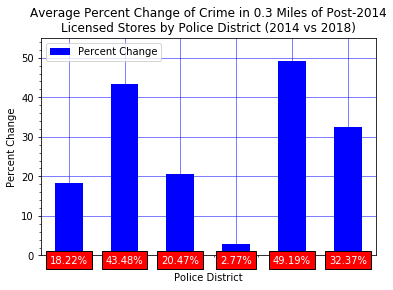

In [120]:
# Cell 119
# Graph Average Percent Change of Crimes within 0.5 Miles of Selected Post-2014 Licensed Stores (2014 -2018)

# Storing the number of Dispensaries to be used as labels on the graph
labels = []

# Creating summary dataframe for graphing purposes
post_14_percent_change_analysis = post_14_selected_stores_df.groupby(["Police District"])["Percent Change"].mean()
post_14_percent_change_analysis_df = pd.DataFrame(post_14_percent_change_analysis)

# Record values to the list above for use as labels
for row in post_14_percent_change_analysis_df.iterrows():
    labels.append(row[1][0])

# Create plot and format as needed
post_14_percent_change_analysis_df.plot(kind="bar", color = "blue")
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='blue')
plt.title("Average Percent Change of Crime in 0.3 Miles of Post-2014\nLicensed Stores by Police District (2014 vs 2018)")
plt.xlabel("Police District")
plt.ylabel("Percent Change")
plt.ylim(0,55)
# Labeler Loop
for district, value in enumerate(labels):
    plt.text(district, -2, s=(f'{round(value,2)}%'),horizontalalignment="center",bbox=dict(facecolor='red', alpha=1),color="white")

plt.savefig("Outputs/Post-2014/REVISED Average Change for Selected Post-2014-Licensed Dispensaries per District.png")
plt.show()

In [121]:
# Cell 120
# Plotting both Pre- and Post-2014 Licensed Dispensaries on an interactive map, with Police Districts overlaid

# Create list and column to store the police district each dispensary is in
selected_stores_police_districts = []
post_14_selected_stores_df["Police District"] = ""
coord_Den=[39.7392, -104.9903]

# Create Base Map
base_map = folium.Map(
    width='100%', 
    height='100%',
    location=coord_Den,
    zoom_start=11,
)

denver_map = base_map

# Set pop-ups to identify Police District (To identify a police district, simply click on the desired area)
for district in district_geodata_df.iterrows():
    geojson=folium.GeoJson(district[1][3],name='districts').add_to(denver_map)
    popup = folium.Popup(f'District {district[1][0]}')
    popup.add_to(geojson)
    geojson.add_to(denver_map)

# Identify where pre-2014 stores are and plot them (GREEN MARKERS)
for store in pre_14_selected_stores_df.iterrows():
    coord_DenCrime=[store[1][2], store[1][3]]
    
    folium.Marker(
        location= (coord_DenCrime), 
        popup= store[1][1],
        icon=folium.Icon(color='green', icon='cloud')
    ).add_to(denver_map)
    
    coord_DenCrime.reverse()
    Pt_DenCrime=Point(tuple(coord_DenCrime))
    
# Identify which police district a store's coordinates fall into and record that data
    for i in range(7): 
        if district_geodata_df.geometry[i].contains(Pt_DenCrime):
            selected_stores_police_districts.append(district_geodata_df["DIST_NUM"][i])
        
# Identify where post-2014 stores are and plot them (RED MARKERS)         
for store in post_14_selected_stores_df.iterrows():
    coord_DenCrime=[store[1][2], store[1][3]]
    
    folium.Marker(
        location= (coord_DenCrime), 
        popup= store[1][1],
        icon=folium.Icon(color='red', icon='cloud')
    ).add_to(denver_map)
    
    coord_DenCrime.reverse()
    Pt_DenCrime=Point(tuple(coord_DenCrime))
    
# Identify which police district a store's coordinates fall into and record that data
    for i in range(7): 
        if district_geodata_df.geometry[i].contains(Pt_DenCrime):
            selected_stores_police_districts.append(district_geodata_df["DIST_NUM"][i])
        
denver_map.save("Outputs/Selected pre- AND post-2014 Dispensaries and Police Districts.html")
denver_map

# ANALYSIS OF THE DATA 



# Project:  Crime in Relation to Retail Marijuana Stores In Denver


## Motivation and Background

>We were curious whether legalized recreational maijuana sales were having an affect on crime in Denver.  When there was public discussion prior to legalizing recreational marijuana, one of the expressed concerns was that legalized sales would promote an increase in crime. We found a very robust dataset of Denver crime data.  We also found data for retail stores that were licensed to sell marijuana.  The stores were authorized to start selling recreational marijuana in January 2014.

>We originally set out to look at crime before and after January 2014 in order to compare crime activity before and after legalization.  However, we discovered the available crime data was limited in terms of historical scope and there was no crime data prior to January 2014.  So, we decided to alter our inquiry and look at crime patterns since the legalization of marijuana as described by our key questions that follow.

## Key Questions

### Has per capita crime grown in Denver, since the legalization of marijuana?
### Is there a correlation between the number of marijuana stores by Denver Police District and crime incidents?
### Have crime incidents increased in neighborhoods around new marijuana stores that were licensed in the years following legalization?


## Q1: Has per capita crime grown in Denver, since the legalization of marijuana?

#### For this study, we defined "crime" as an offense (e.g., assault, robbery, theft); there can be multiple offenses per incident.
#### We examined per capita crime rates in the City of Denver, since the legalization of recreational marijuana in January 2014.
#### Per capita crime grew in the first year after legalization, but has since leveled off.

* Per capita crime increased by 5% from 2014 to 2015 when stores grew by 20%
* Per capita crime growth has been flat since 2015, while stores continued to grow by 12% thru 2017


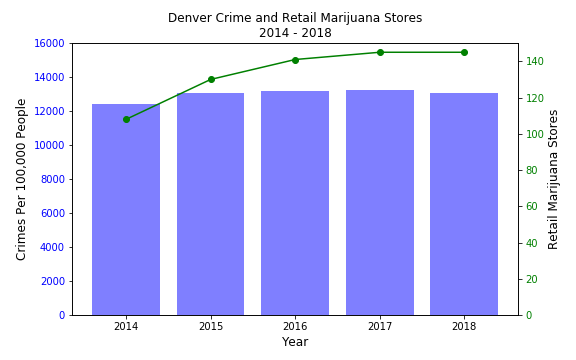

## Q2: Is there a correlation between the number of marijuana stores by Denver Police District and crime?

#### There are seven Denver Police Districts, but District 7 is an outlyer, since it is comprised entirely by Denver International Airport (with no active dispensaries in or around the airport), and will be ignored in the following observations.

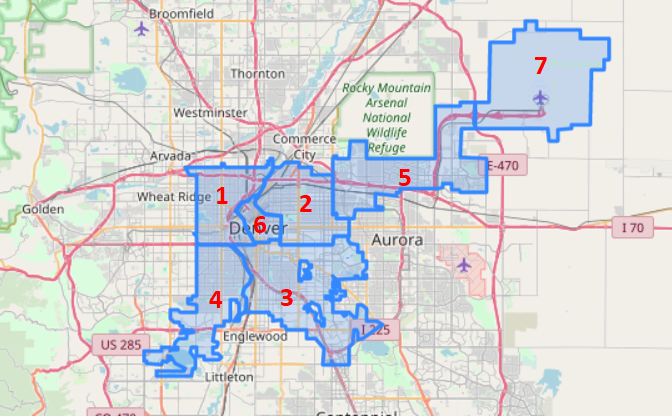

#### Total number of marijuana dispensaries (retail stores) by Denver Police District

* Police Districts 2 and 3 have 50-100% more stores than Districts 1, 4 and 6
* District 5 has far fewer stores

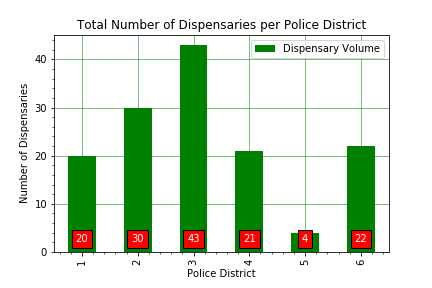

#### Police District findings are mixed:

* District 3 had the highest crime and highest number of stores (seemingly a positive correlation)
* Despite having a third fewer stores than District 2, Districts 1 and 6 have higher crime and higher % growth in crime (apparently negative correlations)

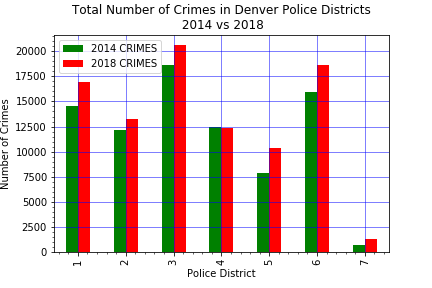    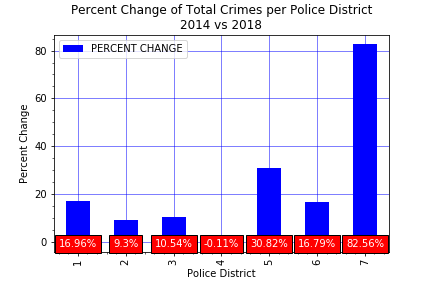

## Q3: Has crime increased in neighborhoods around marijuana stores that were newly licensed in the years following legalization?

We took a before-after approach to this question.  Even though we did not have crime data prior to legalization of marijuana, we did have retail stores that were license to sell in the years after marijuana was legalized.  So, for this sample of stores, we were able to look at crime in their neighborhoods before and after they were licensed to sell. Here is the approach we took:

1. select stores licensed after 2014 and before 2018 (2015 and 2016 licensees, aka post-2014 stores, n= 33)
1. execute API calls to Google Geo to append lat-lngs to the store addresses and identify their location
1. count cumulative crimes within a mile of each store location (using 0.1 mile increments):

    1. for year 2018 after the store was licensed 
    1. for year 2014 before the store was licensed (using same store location)
    
1. using aggregated store data, calculate the mean number of cumulative crimes by distance from store
1. using aggregated store data, calculate the % change in mean cumulative crime for 2018 vs 2014 by distance from store

For comparison, we also compiled the same data as above for stores that were in existence during both 2014 and 2018 (2013 licensees, aka pre-2014 stores, n= 83).


#### There may be a localized effect of introducing a new marijuana store into a neighborhood.  While we can't prove causation, there appears to be a positive correlation between new retail marijuana stores and a % increase in neighborhood crime.

* Within 0.4 miles of the store location, new stores have a much higher % growth in crime than pre-existing stores
* At half mile or more, % growth in crime is similar, if not lower, for new stores compared to pre-existiing stores (any store-related crime affect gets diluted as distance from the store increases, possibly due to area overlap with pre-existing stores)


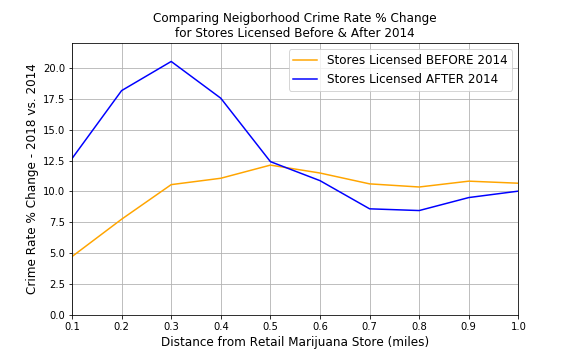

#### In every Police District, it is the same pattern:  % growth in crime is higher for new stores (blue bars below), than it is for pre-existing stores (orange bars below).


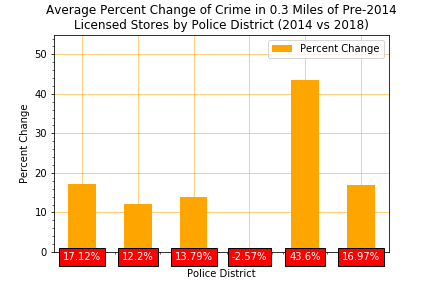)


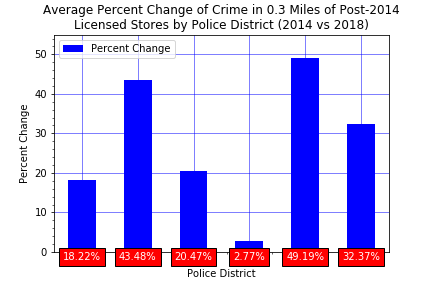

## Summary Takeaways

#### Looking at the big picture, there appears to be no obvious correlation between the number of marijuana stores in Denver and crime incidence since legalization

* After rising briefly in the year after legalization, per capita crime has flattened while retail marijuana stores have grown modestly
* Police District findings were mixed given that some Districts showed positive correlation between crime and the number of retail stores, whereas other Districts exhibited negative correlation.

#### There may be a positive correlation between new retail maijuana stores and a % increase in neighborhood crime incidents.

* Within 0.4 miles of the store location, new stores have a much higher % growth in crime than pre-existing stores

#### Thoughts on further analysis:

1. Examine the crime incidence and change rates for different categories of crime:

    * drug-related offenses
    * "taking stuff” offenses (theft, burglary, larceny, robbery, etc.)
    * white collar crime
    * violent crime
    * marijuana possession  (even after legalization, it can be a crime under some circumstances)
    
    
2. Replicate the “new store in the neighborhood” study after close of 2019 crime year, for example:

    * sample newly licensed stores in 2017 and 2018
    * compare crime change from 2016 vs. 2019

## Data Sources

* Crime data: [kaggle](https://www.kaggle.com/paultimothymooney/denver-crime-data)
* Population data (uses 2010 US Census as a base for further estimates): [live population](http://livepopulationof.com/population-of-denver/)
* Marijuana business licenses:  [Denver Open Data Catalog>Marijuana Active Business Licenses](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-marijuana-active-business-licenses)
* Denver Police Districts and Shapefile: [Denver Open Data Catalog>Police Districts](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-police-districts)
* Google Geocoding for store lat-lngs: [Google Geocoding API](https://developers.google.com/maps/documentation/geocoding/start)
